In [ ]:
pip install deepface tensorflow facenet-pytorch torch torchvision scikit-learn

In [ ]:
!pip install deepface pandas opencv-python

# Loading Dataset

In [ ]:
import os
import glob
import random

# Define the base path to your dataset folder in Google Drive
base_path = "/content/drive/MyDrive/Face_Recognition_Data"

# Function to get image pairs from the directory
def get_image_pairs(base_path, is_similar=True):
    img_paths = []

    # Get a list of all person folders (e.g., person1, person2, ...)
    person_folders = os.listdir(base_path)

    # Loop through all person folders
    for person_folder in person_folders:
        person_folder_path = os.path.join(base_path, person_folder)

        # Ensure the folder is a directory
        if os.path.isdir(person_folder_path):
            # Check for the aadhar photo with the new naming convention
            aadhar_image = os.path.join(person_folder_path, "xml_aadhar_photo.jpg")

            # Use glob to get any file that ends with _0_kyc.jpg in the person's folder
            kyc_images = glob.glob(os.path.join(person_folder_path, "*_0_KYC.jpg"))

            # Check if both aadhar image and at least one kyc image exist
            if os.path.exists(aadhar_image) and kyc_images:
                # Loop through all found kyc images (if multiple exist)
                for kyc_image in kyc_images:
                    # If it's a similar pair, just add the pair
                    if is_similar:
                        img_paths.append([aadhar_image, kyc_image])
                    # If it's a dissimilar pair, make sure to select from a different folder
                    else:
                        # Find another random folder that is not the same as the current folder
                        different_person_folder = random.choice([folder for folder in person_folders if folder != person_folder])
                        different_person_folder_path = os.path.join(base_path, different_person_folder)

                        # Check for the aadhar photo in the different folder
                        different_aadhar_image = os.path.join(different_person_folder_path, "xml_aadhar_photo.jpg")

                        # Use glob to get any file that ends with _0_kyc.jpg in the different person's folder
                        different_kyc_images = glob.glob(os.path.join(different_person_folder_path, "*_0_KYC.jpg"))

                        # Check if both aadhar image and at least one kyc image exist for the different folder
                        if os.path.exists(different_aadhar_image) and different_kyc_images:
                            different_kyc_image = random.choice(different_kyc_images)  # Pick a random kyc image from the different folder
                            img_paths.append([aadhar_image, different_kyc_image])

    return img_paths

# Get similar image pairs (limit to 5 folders for testing)
img_paths_similar = get_image_pairs(base_path, is_similar=True)
print(len(img_paths_similar))
# Get dissimilar image pairs (limit to 5 folders for testing)
# img_paths_dissimilar = get_image_pairs(base_path, is_similar=False)

# Optionally, print the first few similar and dissimilar pairs to verify
# print("Similar Pairs:")
# for pair in img_paths_similar:  # Print the first 5 similar pairs
#     print(pair)

# # print("\nDissimilar Pairs:")
# for pair in img_paths_dissimilar:  # Print the first 5 dissimilar pairs
#     print(pair)


1725


## Loading for 2 paths

In [ ]:
import os
import glob
import random

def get_image_pairs_multiple_bases(base_paths, is_similar=True):
    img_paths = []

    for base_path in base_paths:
        person_folders = os.listdir(base_path)

        for person_folder in person_folders:
            if person_folder.endswith("0"):
              # print(person_folder)
              pass
            person_folder_path = os.path.join(base_path, person_folder)

            if os.path.isdir(person_folder_path):
                aadhar_image = os.path.join(person_folder_path, "xml_aadhar_photo.jpg")
                kyc_images = glob.glob(os.path.join(person_folder_path, "*_0_KYC.jpg"))

                if os.path.exists(aadhar_image) and kyc_images:
                    for kyc_image in kyc_images:
                        if is_similar:
                            img_paths.append([aadhar_image, kyc_image])
                        else:
                            different_person_folder = random.choice(
                                [folder for folder in person_folders if folder != person_folder]
                            )
                            different_person_folder_path = os.path.join(base_path, different_person_folder)
                            different_aadhar_image = os.path.join(different_person_folder_path, "xml_aadhar_photo.jpg")
                            different_kyc_images = glob.glob(os.path.join(different_person_folder_path, "*_0_KYC.jpg"))

                            if os.path.exists(different_aadhar_image) and different_kyc_images:
                                different_kyc_image = random.choice(different_kyc_images)
                                img_paths.append([aadhar_image, different_kyc_image])
    return img_paths

# Combine both base paths
all_base_paths = ["/content/drive/MyDrive/Face_Recognition_Data", "/content/drive/MyDrive/Face_Recognition_Data_1"]

# Get similar image pairs from both folders
img_paths_similar = get_image_pairs_multiple_bases(all_base_paths, is_similar=True)

print(f"Total similar image pairs: {len(img_paths_similar)}")

# Print a few for verification
# for pair in img_paths_similar[40:45]:
#     print(pair)


Total similar image pairs: 2332


# Training model(Fine tuning)

In [ ]:
import os
import torch
import numpy as np
import cv2
from sklearn.preprocessing import LabelEncoder
from facenet_pytorch import InceptionResnetV1
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch import nn, optim
from PIL import Image
from torchvision import transforms
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained FaceNet model (InceptionResnetV1)
model = InceptionResnetV1(pretrained='vggface2').eval().to(device)

# Freeze the pre-trained layers (InceptionResnetV1 model)
for param in model.parameters():
    param.requires_grad = False  # Freeze all parameters of the InceptionResnetV1 model

# Add new fully connected layers on top for fine-tuning

transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# transform = transforms.Compose([
#     transforms.Resize((160, 160)),
#     transforms.RandomHorizontalFlip(p=0.5),          # flip half the time
#     transforms.RandomRotation(degrees=10),           # rotate ±10 degrees
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
#     transforms.ToTensor(),
#     transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
# ])


face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def get_embeddings(image_paths, model, device='cpu'):
    embeddings = []
    labels = []

    for label, person_images in enumerate(image_paths):
        print(label)
        for img_path in person_images:
            try:
              img = Image.open(img_path).convert("RGB")
              img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
              gray = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)
              faces = face_cascade.detectMultiScale(gray, 1.1, 4)

              if len(faces) > 0:
                  for (x, y, w, h) in faces:
                      face = img_cv[y:y+h, x:x+w]
                      face_pil = Image.fromarray(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
                      face_tensor = transform(face_pil).unsqueeze(0).to(device)  # Add batch dimension

                      with torch.no_grad():
                          embedding = model(face_tensor)  # Get the embedding
                      embeddings.append(embedding.cpu().detach().numpy())
                      labels.append(label)

            except Exception as e:
              print(f"Error processing image {img_path}: {e}")
              continue

    return np.vstack(embeddings), np.array(labels)

# Define image paths (list of paths to the images)
# image_paths = [
#     ['/content/person2/aadhar_image_2.jpg', '/content/person2/kyc_image_2.jpg'],  # Images of person 2
#     ['/content/person1/aadhar_image_1.jpg', '/content/person1/kyc_image_1.jpg'],  # Images of person 1
#     ['/content/person3/aadhar_image_4.jpg', '/content/person3/kyc_image_4.jpg']   # Images of person 3
# ]

# Get the embeddings and labels from the images
embeddings, labels = get_embeddings(img_paths_similar, model, device)

# Print embeddings and labels
print("Embeddings:")
print(embeddings)
print("Labels:")
print(labels)

# Label encoding (turn the labels into integers)
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

# Define a custom dataset to handle the embeddings and labels
class EmbeddingDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.embeddings[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

# Create dataset and dataloaders
train_dataset = EmbeddingDataset(embeddings, labels_encoded)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Fine-tuned FaceNet model
class FineTunedFaceNet(nn.Module):
    def __init__(self, base_model, num_classes):
        super(FineTunedFaceNet, self).__init__()
        self.base_model = base_model  # The pre-trained FaceNet model
        self.fc = nn.Linear(512, num_classes)  # Fully connected layer to classify into different classes

    def forward(self, x):
        return self.fc(x)  # Directly pass the embeddings through the fully connected layer

# Define the number of classes
num_classes = len(set(labels_encoded))

# Instantiate the fine-tuned model, passing the pre-trained model and number of classes
fine_tuned_model = FineTunedFaceNet(model, num_classes).to(device)

# Only train the new fully connected layers (fc)
optimizer = optim.Adam(fine_tuned_model.fc.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    fine_tuned_model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        # Pass the embeddings through the fully connected layers
        outputs = fine_tuned_model(inputs.to(device))
        loss = loss_fn(outputs, labels.to(device))

        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

# Save the fine-tuned model
os.makedirs('/content/drive/MyDrive/FineTuningModel', exist_ok=True)

save_path = '/content/drive/MyDrive/FineTuningModel/fine_tuned_model_1.pth'
torch.save(fine_tuned_model.state_dict(), save_path)
print(f"Fine-tuned model saved to {save_path}")


  0%|          | 0.00/107M [00:00<?, ?B/s]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
Error processing image /content/drive/MyDrive/Face_Recognition_Data/person1725/AFZPJ5572J_0_KYC.jpg: cannot identify image file '/content/drive/MyDrive/Face_Recognition_Data/person1725/AFZPJ5572J_0_KYC.jpg'
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225

## Can You Use the Fine-Tuned Model Without the Original FaceNet Model and deepface?
Yes, you can use the fine_tuned_model.pth file independently for face comparison.

This fine-tuned model already contains the necessary learned weights (both from the pre-trained FaceNet and the additional fully connected layer you trained).

## The fine-tuned model is essentially a new model built on top of FaceNet’s features.

All the learning from both the pre-trained FaceNet and your dataset is embedded in fine_tuned_model.pth.

You don’t need the original FaceNet model when using fine_tuned_model.pth for face comparisons because the fine-tuned model includes everything required for predictions.

🚨 What Could Go Wrong in the Future?
Model Dependency on Frameworks:

If the PyTorch version or facenet-pytorch library changes significantly in the future, you might face compatibility issues when loading the model.

Fix: Make sure to keep the environment consistent, or save the model using a format like TorchScript for better portability.

Data Distribution Shift:

If the future images are very different from the data you used to fine-tune the model (e.g., different lighting, angles, etc.), the performance might degrade.

Fix: Consider periodically retraining or fine-tuning with new data.

Model Degradation (Overfitting Issues):

If your fine-tuned model overfitted the training data, it might not generalize well to new faces.

Fix: Regularization during training, or using more diverse data.



# Prediction using fine tuned model

##TEST

# fine tune triplet loss

In [ ]:
import os
import torch
import numpy as np
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from facenet_pytorch import InceptionResnetV1, MTCNN
from PIL import Image, UnidentifiedImageError
from sklearn.model_selection import train_test_split
import random
from tqdm import tqdm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on device: {device}")

# Preprocessing
# transform = transforms.Compose([
#     transforms.Resize((160, 160)),
#     transforms.ToTensor(),
#     transforms.Normalize([0.5], [0.5])
# ])


transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.RandomHorizontalFlip(p=0.5),          # flip half the time
    transforms.RandomRotation(degrees=10),           # rotate ±10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])


# Load FaceNet base model
facenet = InceptionResnetV1(pretrained='vggface2').to(device)
facenet.eval()

# Freeze all layers
for param in facenet.parameters():
    param.requires_grad = False


for name, param in list(facenet.named_parameters())[-10:]:  # Unfreeze last 10 parameters
    param.requires_grad = True
    print(f"Unfreezing layer: {name}")

# MTCNN for face detection
mtcnn = MTCNN(image_size=160, margin=0, device=device)

# ===== Dataset for Triplet Loss =====

class TripletFaceDataset(Dataset):
    def __init__(self, image_paths, transform):
        self.transform = transform
        self.data = image_paths
        self.classes = list(image_paths.keys())

    def __len__(self):
        return len(self.classes) * 5  # Or any number you want

    def __getitem__(self, idx):
        # while True:  # Keep trying until a valid triplet is returned
            # print('bad image trying loop',self.data)
        try:
            anchor_class = random.choice(self.classes)
            negative_class = random.choice([c for c in self.classes if c != anchor_class])

            anchor_img_path = random.choice(self.data[anchor_class])
            positive_img_path = random.choice(self.data[anchor_class])
            negative_img_path = random.choice(self.data[negative_class])

            anchor_img = Image.open(anchor_img_path).convert("RGB")
            positive_img = Image.open(positive_img_path).convert("RGB")
            negative_img = Image.open(negative_img_path).convert("RGB")

            anchor_tensor = self.transform(anchor_img)
            positive_tensor = self.transform(positive_img)
            negative_tensor = self.transform(negative_img)

            return anchor_tensor, positive_tensor, negative_tensor

        except (IOError, OSError, UnidentifiedImageError) as e:
            print(f"Warning: Skipping a corrupted or unreadable image. Error: {e}")
            return None
            # Continue the while loop to try another triplet


# class TripletFaceDataset(Dataset):
#     def __init__(self, image_paths, transform):
#         self.transform = transform
#         self.data = image_paths
#         self.classes = list(image_paths.keys())

#     def __len__(self):
#         return len(self.classes) * 5  # depends on how many triplets you want

#     def __getitem__(self, idx):
#         anchor_class = random.choice(self.classes)
#         negative_class = random.choice([c for c in self.classes if c != anchor_class])

#         anchor_img = Image.open(random.choice(self.data[anchor_class])).convert("RGB")
#         positive_img = Image.open(random.choice(self.data[anchor_class])).convert("RGB")
#         negative_img = Image.open(random.choice(self.data[negative_class])).convert("RGB")

#         anchor_tensor = self.transform(anchor_img)
#         positive_tensor = self.transform(positive_img)
#         negative_tensor = self.transform(negative_img)

#         return anchor_tensor, positive_tensor, negative_tensor

# === Triplet Loss Function ===
class TripletNet(nn.Module):
    def __init__(self, model):
        super(TripletNet, self).__init__()
        self.model = model

    def forward(self, anchor, positive, negative):
        embedded_a = self.model(anchor)
        embedded_p = self.model(positive)
        embedded_n = self.model(negative)
        return embedded_a, embedded_p, embedded_n

triplet_model = TripletNet(facenet).to(device)
criterion = nn.TripletMarginLoss(margin=1.0, p=2)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, triplet_model.parameters()), lr=0.0005)

# ===== Your Dataset (Dictionary format: {'person_id': [list of image paths]}) =====
# For example:
# dataset = {
#     "person1": ["/path/to/img1.jpg", "/path/to/img2.jpg"],
#     "person2": ["/path/to/img3.jpg", "/path/to/img4.jpg"],
#     ...
# }
# You need to build this dictionary before continuing

# Assume you already have this as `dataset`

# Example input
your_list_dataset = img_paths_similar

# Convert to dictionary format for training
dataset = {str(i): imgs for i, imgs in enumerate(your_list_dataset)}

# dataset = your_prepared_data_dict
def custom_collate(batch):
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return None
    return torch.utils.data.dataloader.default_collate(batch)


# === Dataloader ===
train_dataset = TripletFaceDataset(dataset, transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=custom_collate)

# === Training ===
num_epochs = 5
for epoch in range(num_epochs):
    triplet_model.train()
    total_loss = 0
    for batch in train_loader:
        if batch is None:
          continue  # Skip incomplete or corrupted batch
        anchor, positive, negative = [x.to(device) for x in batch]

        embedded_a, embedded_p, embedded_n = triplet_model(anchor, positive, negative)
        loss = criterion(embedded_a, embedded_p, embedded_n)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()



    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}")

# Save the fine-tuned model
save_path = '/content/drive/MyDrive/FineTuningModel/facenet_triplet_finetuned.pth'
torch.save(triplet_model.state_dict(), save_path)
print(f"✅ Fine-tuned model saved at: {save_path}")


Running on device: cpu
Unfreezing layer: block8.branch1.2.conv.weight
Unfreezing layer: block8.branch1.2.bn.weight
Unfreezing layer: block8.branch1.2.bn.bias
Unfreezing layer: block8.conv2d.weight
Unfreezing layer: block8.conv2d.bias
Unfreezing layer: last_linear.weight
Unfreezing layer: last_bn.weight
Unfreezing layer: last_bn.bias
Unfreezing layer: logits.weight
Unfreezing layer: logits.bias
Epoch 1/5, Loss: 0.3941


KeyboardInterrupt: 

In [ ]:
import torch
from facenet_pytorch import InceptionResnetV1
from torch import nn

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model structure
class FineTunedFaceNet(nn.Module):
    def __init__(self, base_model, num_classes):
        super().__init__()
        self.base_model = base_model
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        return self.fc(x)

# Load base FaceNet model
# Load the state_dict first
state_dict = torch.load('/content/drive/MyDrive/FineTuningModel/fine_tuned_model_1.pth', map_location=device)

# Dynamically get number of output classes
num_classes = state_dict['fc.weight'].size(0)

# Build model accordingly
base_model = InceptionResnetV1(pretrained='vggface2').eval().to(device)

model_ft = FineTunedFaceNet(base_model, num_classes)
model_ft.load_state_dict(state_dict)
model_ft.to(device)
model_ft.eval()


FineTunedFaceNet(
  (base_model): InceptionResnetV1(
    (conv2d_1a): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (conv2d_2a): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (conv2d_2b): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2d_3b): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affin

  0%|          | 0.00/107M [00:00<?, ?B/s]

✅ Fine-tuned model loaded.


In [ ]:
import torch
from facenet_pytorch import InceptionResnetV1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the same FineTunedFaceNet class as used in training:
class FineTunedFaceNet(torch.nn.Module):
    def __init__(self, base_model, num_classes):
        super(FineTunedFaceNet, self).__init__()
        self.base_model = base_model
        self.fc = torch.nn.Linear(512, num_classes)  # Fully connected layer as before

    def forward(self, x):
        # x is expected to be embeddings (512-d), so directly pass through fc
        return self.fc(x)

# Suppose your num_classes during training was 2331 (replace with your actual number)
num_classes = 2331

# Load base model without pretrained weights (to avoid mismatch)
base_model = InceptionResnetV1(pretrained='vggface2').eval().to(device)

# Initialize your fine-tuned model with base model and num_classes
fine_tuned_model = FineTunedFaceNet(base_model, num_classes).to(device)

# Load saved weights
model_path = '/content/drive/MyDrive/FineTuningModel/fine_tuned_model_1.pth'
state_dict = torch.load(model_path, map_location=device)
fine_tuned_model.load_state_dict(state_dict)
fine_tuned_model.eval()

print("✅ Fine-tuned model loaded successfully!")


✅ Fine-tuned model loaded successfully!


In [10]:
import torch
import numpy as np
from PIL import Image
from facenet_pytorch import InceptionResnetV1, MTCNN
from sklearn.metrics.pairwise import cosine_similarity
import os
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on device: {device}")

# Define FineTunedFaceNet with fc layer
class FineTunedFaceNet(torch.nn.Module):
    def __init__(self, base_model, num_classes):
        super(FineTunedFaceNet, self).__init__()
        self.base_model = base_model
        self.fc = torch.nn.Linear(512, num_classes)

    def forward(self, x):
        return self.fc(x)

# Load base FaceNet model (pretrained)
base_model = InceptionResnetV1(pretrained='vggface2').eval().to(device)

# Load fine-tuned model
num_classes = 2331
fine_tuned_model = FineTunedFaceNet(base_model, num_classes).to(device)
model_path = '/content/drive/MyDrive/FineTuningModel/facenet_triplet_finetuned.pth'

if os.path.exists(model_path):
    state_dict = torch.load(model_path, map_location=device)
    fine_tuned_model.load_state_dict(state_dict)
    fine_tuned_model.eval()
    print("✅ Fine-tuned model loaded successfully.")
else:
    print("⚠️ Fine-tuned model not found, using base model only.")
    fine_tuned_model = None

# MTCNN face detector for aligned crops
mtcnn = MTCNN(image_size=160, margin=0, device=device)

def get_embedding(model, image_path):
    img = Image.open(image_path).convert('RGB')
    face = mtcnn(img)
    if face is None:
        print(f"⚠️ No face detected in {image_path}")
        return None, img
    face = face.unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = model(face)
    return embedding.cpu().numpy(), img

def compare_embeddings(emb1, emb2, threshold=0.5):
    if emb1 is None or emb2 is None:
        return None, "❌ Missing embedding(s)"
    sim = cosine_similarity(emb1, emb2)[0][0]
    return sim, "✅ Same person" if sim > threshold else "❌ Different people"

def show_images(img1, img2, title1="Image 1", title2="Image 2"):
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(img1)
    plt.title(title1)
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(img2)
    plt.title(title2)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Test images (change paths to your test images)
image1_path = '/content/drive/MyDrive/Face_Recognition_Data/person213/CHTPJ2373M_0_KYC.jpg'
image2_path = '/content/drive/MyDrive/Face_Recognition_Data/person453/xml_aadhar_photo.jpg'

# Get embeddings from base model
base_emb1, img1 = get_embedding(base_model, image1_path)
base_emb2, img2 = get_embedding(base_model, image2_path)

# Get embeddings from fine-tuned model if loaded
if fine_tuned_model is not None:
    with torch.no_grad():
        # Pass base embeddings through fc layer
        ft_emb1 = fine_tuned_model.fc(torch.tensor(base_emb1, dtype=torch.float32).to(device)).cpu().numpy()
        ft_emb2 = fine_tuned_model.fc(torch.tensor(base_emb2, dtype=torch.float32).to(device)).cpu().numpy()
else:
    ft_emb1, ft_emb2 = None, None

# Compare base model embeddings
base_sim, base_res = compare_embeddings(base_emb1, base_emb2)
print(f"Base model similarity: {base_sim*100:.2f}% - {base_res}")

# Compare fine-tuned model embeddings if available
if ft_emb1 is not None and ft_emb2 is not None:
    ft_sim, ft_res = compare_embeddings(ft_emb1, ft_emb2)
    print(f"Fine-tuned model similarity: {ft_sim*100:.2f}% - {ft_res}")

# Show the images
show_images(img1, img2)



Running on device: cpu


RuntimeError: Error(s) in loading state_dict for FineTunedFaceNet:
	Missing key(s) in state_dict: "base_model.conv2d_1a.conv.weight", "base_model.conv2d_1a.bn.weight", "base_model.conv2d_1a.bn.bias", "base_model.conv2d_1a.bn.running_mean", "base_model.conv2d_1a.bn.running_var", "base_model.conv2d_2a.conv.weight", "base_model.conv2d_2a.bn.weight", "base_model.conv2d_2a.bn.bias", "base_model.conv2d_2a.bn.running_mean", "base_model.conv2d_2a.bn.running_var", "base_model.conv2d_2b.conv.weight", "base_model.conv2d_2b.bn.weight", "base_model.conv2d_2b.bn.bias", "base_model.conv2d_2b.bn.running_mean", "base_model.conv2d_2b.bn.running_var", "base_model.conv2d_3b.conv.weight", "base_model.conv2d_3b.bn.weight", "base_model.conv2d_3b.bn.bias", "base_model.conv2d_3b.bn.running_mean", "base_model.conv2d_3b.bn.running_var", "base_model.conv2d_4a.conv.weight", "base_model.conv2d_4a.bn.weight", "base_model.conv2d_4a.bn.bias", "base_model.conv2d_4a.bn.running_mean", "base_model.conv2d_4a.bn.running_var", "base_model.conv2d_4b.conv.weight", "base_model.conv2d_4b.bn.weight", "base_model.conv2d_4b.bn.bias", "base_model.conv2d_4b.bn.running_mean", "base_model.conv2d_4b.bn.running_var", "base_model.repeat_1.0.branch0.conv.weight", "base_model.repeat_1.0.branch0.bn.weight", "base_model.repeat_1.0.branch0.bn.bias", "base_model.repeat_1.0.branch0.bn.running_mean", "base_model.repeat_1.0.branch0.bn.running_var", "base_model.repeat_1.0.branch1.0.conv.weight", "base_model.repeat_1.0.branch1.0.bn.weight", "base_model.repeat_1.0.branch1.0.bn.bias", "base_model.repeat_1.0.branch1.0.bn.running_mean", "base_model.repeat_1.0.branch1.0.bn.running_var", "base_model.repeat_1.0.branch1.1.conv.weight", "base_model.repeat_1.0.branch1.1.bn.weight", "base_model.repeat_1.0.branch1.1.bn.bias", "base_model.repeat_1.0.branch1.1.bn.running_mean", "base_model.repeat_1.0.branch1.1.bn.running_var", "base_model.repeat_1.0.branch2.0.conv.weight", "base_model.repeat_1.0.branch2.0.bn.weight", "base_model.repeat_1.0.branch2.0.bn.bias", "base_model.repeat_1.0.branch2.0.bn.running_mean", "base_model.repeat_1.0.branch2.0.bn.running_var", "base_model.repeat_1.0.branch2.1.conv.weight", "base_model.repeat_1.0.branch2.1.bn.weight", "base_model.repeat_1.0.branch2.1.bn.bias", "base_model.repeat_1.0.branch2.1.bn.running_mean", "base_model.repeat_1.0.branch2.1.bn.running_var", "base_model.repeat_1.0.branch2.2.conv.weight", "base_model.repeat_1.0.branch2.2.bn.weight", "base_model.repeat_1.0.branch2.2.bn.bias", "base_model.repeat_1.0.branch2.2.bn.running_mean", "base_model.repeat_1.0.branch2.2.bn.running_var", "base_model.repeat_1.0.conv2d.weight", "base_model.repeat_1.0.conv2d.bias", "base_model.repeat_1.1.branch0.conv.weight", "base_model.repeat_1.1.branch0.bn.weight", "base_model.repeat_1.1.branch0.bn.bias", "base_model.repeat_1.1.branch0.bn.running_mean", "base_model.repeat_1.1.branch0.bn.running_var", "base_model.repeat_1.1.branch1.0.conv.weight", "base_model.repeat_1.1.branch1.0.bn.weight", "base_model.repeat_1.1.branch1.0.bn.bias", "base_model.repeat_1.1.branch1.0.bn.running_mean", "base_model.repeat_1.1.branch1.0.bn.running_var", "base_model.repeat_1.1.branch1.1.conv.weight", "base_model.repeat_1.1.branch1.1.bn.weight", "base_model.repeat_1.1.branch1.1.bn.bias", "base_model.repeat_1.1.branch1.1.bn.running_mean", "base_model.repeat_1.1.branch1.1.bn.running_var", "base_model.repeat_1.1.branch2.0.conv.weight", "base_model.repeat_1.1.branch2.0.bn.weight", "base_model.repeat_1.1.branch2.0.bn.bias", "base_model.repeat_1.1.branch2.0.bn.running_mean", "base_model.repeat_1.1.branch2.0.bn.running_var", "base_model.repeat_1.1.branch2.1.conv.weight", "base_model.repeat_1.1.branch2.1.bn.weight", "base_model.repeat_1.1.branch2.1.bn.bias", "base_model.repeat_1.1.branch2.1.bn.running_mean", "base_model.repeat_1.1.branch2.1.bn.running_var", "base_model.repeat_1.1.branch2.2.conv.weight", "base_model.repeat_1.1.branch2.2.bn.weight", "base_model.repeat_1.1.branch2.2.bn.bias", "base_model.repeat_1.1.branch2.2.bn.running_mean", "base_model.repeat_1.1.branch2.2.bn.running_var", "base_model.repeat_1.1.conv2d.weight", "base_model.repeat_1.1.conv2d.bias", "base_model.repeat_1.2.branch0.conv.weight", "base_model.repeat_1.2.branch0.bn.weight", "base_model.repeat_1.2.branch0.bn.bias", "base_model.repeat_1.2.branch0.bn.running_mean", "base_model.repeat_1.2.branch0.bn.running_var", "base_model.repeat_1.2.branch1.0.conv.weight", "base_model.repeat_1.2.branch1.0.bn.weight", "base_model.repeat_1.2.branch1.0.bn.bias", "base_model.repeat_1.2.branch1.0.bn.running_mean", "base_model.repeat_1.2.branch1.0.bn.running_var", "base_model.repeat_1.2.branch1.1.conv.weight", "base_model.repeat_1.2.branch1.1.bn.weight", "base_model.repeat_1.2.branch1.1.bn.bias", "base_model.repeat_1.2.branch1.1.bn.running_mean", "base_model.repeat_1.2.branch1.1.bn.running_var", "base_model.repeat_1.2.branch2.0.conv.weight", "base_model.repeat_1.2.branch2.0.bn.weight", "base_model.repeat_1.2.branch2.0.bn.bias", "base_model.repeat_1.2.branch2.0.bn.running_mean", "base_model.repeat_1.2.branch2.0.bn.running_var", "base_model.repeat_1.2.branch2.1.conv.weight", "base_model.repeat_1.2.branch2.1.bn.weight", "base_model.repeat_1.2.branch2.1.bn.bias", "base_model.repeat_1.2.branch2.1.bn.running_mean", "base_model.repeat_1.2.branch2.1.bn.running_var", "base_model.repeat_1.2.branch2.2.conv.weight", "base_model.repeat_1.2.branch2.2.bn.weight", "base_model.repeat_1.2.branch2.2.bn.bias", "base_model.repeat_1.2.branch2.2.bn.running_mean", "base_model.repeat_1.2.branch2.2.bn.running_var", "base_model.repeat_1.2.conv2d.weight", "base_model.repeat_1.2.conv2d.bias", "base_model.repeat_1.3.branch0.conv.weight", "base_model.repeat_1.3.branch0.bn.weight", "base_model.repeat_1.3.branch0.bn.bias", "base_model.repeat_1.3.branch0.bn.running_mean", "base_model.repeat_1.3.branch0.bn.running_var", "base_model.repeat_1.3.branch1.0.conv.weight", "base_model.repeat_1.3.branch1.0.bn.weight", "base_model.repeat_1.3.branch1.0.bn.bias", "base_model.repeat_1.3.branch1.0.bn.running_mean", "base_model.repeat_1.3.branch1.0.bn.running_var", "base_model.repeat_1.3.branch1.1.conv.weight", "base_model.repeat_1.3.branch1.1.bn.weight", "base_model.repeat_1.3.branch1.1.bn.bias", "base_model.repeat_1.3.branch1.1.bn.running_mean", "base_model.repeat_1.3.branch1.1.bn.running_var", "base_model.repeat_1.3.branch2.0.conv.weight", "base_model.repeat_1.3.branch2.0.bn.weight", "base_model.repeat_1.3.branch2.0.bn.bias", "base_model.repeat_1.3.branch2.0.bn.running_mean", "base_model.repeat_1.3.branch2.0.bn.running_var", "base_model.repeat_1.3.branch2.1.conv.weight", "base_model.repeat_1.3.branch2.1.bn.weight", "base_model.repeat_1.3.branch2.1.bn.bias", "base_model.repeat_1.3.branch2.1.bn.running_mean", "base_model.repeat_1.3.branch2.1.bn.running_var", "base_model.repeat_1.3.branch2.2.conv.weight", "base_model.repeat_1.3.branch2.2.bn.weight", "base_model.repeat_1.3.branch2.2.bn.bias", "base_model.repeat_1.3.branch2.2.bn.running_mean", "base_model.repeat_1.3.branch2.2.bn.running_var", "base_model.repeat_1.3.conv2d.weight", "base_model.repeat_1.3.conv2d.bias", "base_model.repeat_1.4.branch0.conv.weight", "base_model.repeat_1.4.branch0.bn.weight", "base_model.repeat_1.4.branch0.bn.bias", "base_model.repeat_1.4.branch0.bn.running_mean", "base_model.repeat_1.4.branch0.bn.running_var", "base_model.repeat_1.4.branch1.0.conv.weight", "base_model.repeat_1.4.branch1.0.bn.weight", "base_model.repeat_1.4.branch1.0.bn.bias", "base_model.repeat_1.4.branch1.0.bn.running_mean", "base_model.repeat_1.4.branch1.0.bn.running_var", "base_model.repeat_1.4.branch1.1.conv.weight", "base_model.repeat_1.4.branch1.1.bn.weight", "base_model.repeat_1.4.branch1.1.bn.bias", "base_model.repeat_1.4.branch1.1.bn.running_mean", "base_model.repeat_1.4.branch1.1.bn.running_var", "base_model.repeat_1.4.branch2.0.conv.weight", "base_model.repeat_1.4.branch2.0.bn.weight", "base_model.repeat_1.4.branch2.0.bn.bias", "base_model.repeat_1.4.branch2.0.bn.running_mean", "base_model.repeat_1.4.branch2.0.bn.running_var", "base_model.repeat_1.4.branch2.1.conv.weight", "base_model.repeat_1.4.branch2.1.bn.weight", "base_model.repeat_1.4.branch2.1.bn.bias", "base_model.repeat_1.4.branch2.1.bn.running_mean", "base_model.repeat_1.4.branch2.1.bn.running_var", "base_model.repeat_1.4.branch2.2.conv.weight", "base_model.repeat_1.4.branch2.2.bn.weight", "base_model.repeat_1.4.branch2.2.bn.bias", "base_model.repeat_1.4.branch2.2.bn.running_mean", "base_model.repeat_1.4.branch2.2.bn.running_var", "base_model.repeat_1.4.conv2d.weight", "base_model.repeat_1.4.conv2d.bias", "base_model.mixed_6a.branch0.conv.weight", "base_model.mixed_6a.branch0.bn.weight", "base_model.mixed_6a.branch0.bn.bias", "base_model.mixed_6a.branch0.bn.running_mean", "base_model.mixed_6a.branch0.bn.running_var", "base_model.mixed_6a.branch1.0.conv.weight", "base_model.mixed_6a.branch1.0.bn.weight", "base_model.mixed_6a.branch1.0.bn.bias", "base_model.mixed_6a.branch1.0.bn.running_mean", "base_model.mixed_6a.branch1.0.bn.running_var", "base_model.mixed_6a.branch1.1.conv.weight", "base_model.mixed_6a.branch1.1.bn.weight", "base_model.mixed_6a.branch1.1.bn.bias", "base_model.mixed_6a.branch1.1.bn.running_mean", "base_model.mixed_6a.branch1.1.bn.running_var", "base_model.mixed_6a.branch1.2.conv.weight", "base_model.mixed_6a.branch1.2.bn.weight", "base_model.mixed_6a.branch1.2.bn.bias", "base_model.mixed_6a.branch1.2.bn.running_mean", "base_model.mixed_6a.branch1.2.bn.running_var", "base_model.repeat_2.0.branch0.conv.weight", "base_model.repeat_2.0.branch0.bn.weight", "base_model.repeat_2.0.branch0.bn.bias", "base_model.repeat_2.0.branch0.bn.running_mean", "base_model.repeat_2.0.branch0.bn.running_var", "base_model.repeat_2.0.branch1.0.conv.weight", "base_model.repeat_2.0.branch1.0.bn.weight", "base_model.repeat_2.0.branch1.0.bn.bias", "base_model.repeat_2.0.branch1.0.bn.running_mean", "base_model.repeat_2.0.branch1.0.bn.running_var", "base_model.repeat_2.0.branch1.1.conv.weight", "base_model.repeat_2.0.branch1.1.bn.weight", "base_model.repeat_2.0.branch1.1.bn.bias", "base_model.repeat_2.0.branch1.1.bn.running_mean", "base_model.repeat_2.0.branch1.1.bn.running_var", "base_model.repeat_2.0.branch1.2.conv.weight", "base_model.repeat_2.0.branch1.2.bn.weight", "base_model.repeat_2.0.branch1.2.bn.bias", "base_model.repeat_2.0.branch1.2.bn.running_mean", "base_model.repeat_2.0.branch1.2.bn.running_var", "base_model.repeat_2.0.conv2d.weight", "base_model.repeat_2.0.conv2d.bias", "base_model.repeat_2.1.branch0.conv.weight", "base_model.repeat_2.1.branch0.bn.weight", "base_model.repeat_2.1.branch0.bn.bias", "base_model.repeat_2.1.branch0.bn.running_mean", "base_model.repeat_2.1.branch0.bn.running_var", "base_model.repeat_2.1.branch1.0.conv.weight", "base_model.repeat_2.1.branch1.0.bn.weight", "base_model.repeat_2.1.branch1.0.bn.bias", "base_model.repeat_2.1.branch1.0.bn.running_mean", "base_model.repeat_2.1.branch1.0.bn.running_var", "base_model.repeat_2.1.branch1.1.conv.weight", "base_model.repeat_2.1.branch1.1.bn.weight", "base_model.repeat_2.1.branch1.1.bn.bias", "base_model.repeat_2.1.branch1.1.bn.running_mean", "base_model.repeat_2.1.branch1.1.bn.running_var", "base_model.repeat_2.1.branch1.2.conv.weight", "base_model.repeat_2.1.branch1.2.bn.weight", "base_model.repeat_2.1.branch1.2.bn.bias", "base_model.repeat_2.1.branch1.2.bn.running_mean", "base_model.repeat_2.1.branch1.2.bn.running_var", "base_model.repeat_2.1.conv2d.weight", "base_model.repeat_2.1.conv2d.bias", "base_model.repeat_2.2.branch0.conv.weight", "base_model.repeat_2.2.branch0.bn.weight", "base_model.repeat_2.2.branch0.bn.bias", "base_model.repeat_2.2.branch0.bn.running_mean", "base_model.repeat_2.2.branch0.bn.running_var", "base_model.repeat_2.2.branch1.0.conv.weight", "base_model.repeat_2.2.branch1.0.bn.weight", "base_model.repeat_2.2.branch1.0.bn.bias", "base_model.repeat_2.2.branch1.0.bn.running_mean", "base_model.repeat_2.2.branch1.0.bn.running_var", "base_model.repeat_2.2.branch1.1.conv.weight", "base_model.repeat_2.2.branch1.1.bn.weight", "base_model.repeat_2.2.branch1.1.bn.bias", "base_model.repeat_2.2.branch1.1.bn.running_mean", "base_model.repeat_2.2.branch1.1.bn.running_var", "base_model.repeat_2.2.branch1.2.conv.weight", "base_model.repeat_2.2.branch1.2.bn.weight", "base_model.repeat_2.2.branch1.2.bn.bias", "base_model.repeat_2.2.branch1.2.bn.running_mean", "base_model.repeat_2.2.branch1.2.bn.running_var", "base_model.repeat_2.2.conv2d.weight", "base_model.repeat_2.2.conv2d.bias", "base_model.repeat_2.3.branch0.conv.weight", "base_model.repeat_2.3.branch0.bn.weight", "base_model.repeat_2.3.branch0.bn.bias", "base_model.repeat_2.3.branch0.bn.running_mean", "base_model.repeat_2.3.branch0.bn.running_var", "base_model.repeat_2.3.branch1.0.conv.weight", "base_model.repeat_2.3.branch1.0.bn.weight", "base_model.repeat_2.3.branch1.0.bn.bias", "base_model.repeat_2.3.branch1.0.bn.running_mean", "base_model.repeat_2.3.branch1.0.bn.running_var", "base_model.repeat_2.3.branch1.1.conv.weight", "base_model.repeat_2.3.branch1.1.bn.weight", "base_model.repeat_2.3.branch1.1.bn.bias", "base_model.repeat_2.3.branch1.1.bn.running_mean", "base_model.repeat_2.3.branch1.1.bn.running_var", "base_model.repeat_2.3.branch1.2.conv.weight", "base_model.repeat_2.3.branch1.2.bn.weight", "base_model.repeat_2.3.branch1.2.bn.bias", "base_model.repeat_2.3.branch1.2.bn.running_mean", "base_model.repeat_2.3.branch1.2.bn.running_var", "base_model.repeat_2.3.conv2d.weight", "base_model.repeat_2.3.conv2d.bias", "base_model.repeat_2.4.branch0.conv.weight", "base_model.repeat_2.4.branch0.bn.weight", "base_model.repeat_2.4.branch0.bn.bias", "base_model.repeat_2.4.branch0.bn.running_mean", "base_model.repeat_2.4.branch0.bn.running_var", "base_model.repeat_2.4.branch1.0.conv.weight", "base_model.repeat_2.4.branch1.0.bn.weight", "base_model.repeat_2.4.branch1.0.bn.bias", "base_model.repeat_2.4.branch1.0.bn.running_mean", "base_model.repeat_2.4.branch1.0.bn.running_var", "base_model.repeat_2.4.branch1.1.conv.weight", "base_model.repeat_2.4.branch1.1.bn.weight", "base_model.repeat_2.4.branch1.1.bn.bias", "base_model.repeat_2.4.branch1.1.bn.running_mean", "base_model.repeat_2.4.branch1.1.bn.running_var", "base_model.repeat_2.4.branch1.2.conv.weight", "base_model.repeat_2.4.branch1.2.bn.weight", "base_model.repeat_2.4.branch1.2.bn.bias", "base_model.repeat_2.4.branch1.2.bn.running_mean", "base_model.repeat_2.4.branch1.2.bn.running_var", "base_model.repeat_2.4.conv2d.weight", "base_model.repeat_2.4.conv2d.bias", "base_model.repeat_2.5.branch0.conv.weight", "base_model.repeat_2.5.branch0.bn.weight", "base_model.repeat_2.5.branch0.bn.bias", "base_model.repeat_2.5.branch0.bn.running_mean", "base_model.repeat_2.5.branch0.bn.running_var", "base_model.repeat_2.5.branch1.0.conv.weight", "base_model.repeat_2.5.branch1.0.bn.weight", "base_model.repeat_2.5.branch1.0.bn.bias", "base_model.repeat_2.5.branch1.0.bn.running_mean", "base_model.repeat_2.5.branch1.0.bn.running_var", "base_model.repeat_2.5.branch1.1.conv.weight", "base_model.repeat_2.5.branch1.1.bn.weight", "base_model.repeat_2.5.branch1.1.bn.bias", "base_model.repeat_2.5.branch1.1.bn.running_mean", "base_model.repeat_2.5.branch1.1.bn.running_var", "base_model.repeat_2.5.branch1.2.conv.weight", "base_model.repeat_2.5.branch1.2.bn.weight", "base_model.repeat_2.5.branch1.2.bn.bias", "base_model.repeat_2.5.branch1.2.bn.running_mean", "base_model.repeat_2.5.branch1.2.bn.running_var", "base_model.repeat_2.5.conv2d.weight", "base_model.repeat_2.5.conv2d.bias", "base_model.repeat_2.6.branch0.conv.weight", "base_model.repeat_2.6.branch0.bn.weight", "base_model.repeat_2.6.branch0.bn.bias", "base_model.repeat_2.6.branch0.bn.running_mean", "base_model.repeat_2.6.branch0.bn.running_var", "base_model.repeat_2.6.branch1.0.conv.weight", "base_model.repeat_2.6.branch1.0.bn.weight", "base_model.repeat_2.6.branch1.0.bn.bias", "base_model.repeat_2.6.branch1.0.bn.running_mean", "base_model.repeat_2.6.branch1.0.bn.running_var", "base_model.repeat_2.6.branch1.1.conv.weight", "base_model.repeat_2.6.branch1.1.bn.weight", "base_model.repeat_2.6.branch1.1.bn.bias", "base_model.repeat_2.6.branch1.1.bn.running_mean", "base_model.repeat_2.6.branch1.1.bn.running_var", "base_model.repeat_2.6.branch1.2.conv.weight", "base_model.repeat_2.6.branch1.2.bn.weight", "base_model.repeat_2.6.branch1.2.bn.bias", "base_model.repeat_2.6.branch1.2.bn.running_mean", "base_model.repeat_2.6.branch1.2.bn.running_var", "base_model.repeat_2.6.conv2d.weight", "base_model.repeat_2.6.conv2d.bias", "base_model.repeat_2.7.branch0.conv.weight", "base_model.repeat_2.7.branch0.bn.weight", "base_model.repeat_2.7.branch0.bn.bias", "base_model.repeat_2.7.branch0.bn.running_mean", "base_model.repeat_2.7.branch0.bn.running_var", "base_model.repeat_2.7.branch1.0.conv.weight", "base_model.repeat_2.7.branch1.0.bn.weight", "base_model.repeat_2.7.branch1.0.bn.bias", "base_model.repeat_2.7.branch1.0.bn.running_mean", "base_model.repeat_2.7.branch1.0.bn.running_var", "base_model.repeat_2.7.branch1.1.conv.weight", "base_model.repeat_2.7.branch1.1.bn.weight", "base_model.repeat_2.7.branch1.1.bn.bias", "base_model.repeat_2.7.branch1.1.bn.running_mean", "base_model.repeat_2.7.branch1.1.bn.running_var", "base_model.repeat_2.7.branch1.2.conv.weight", "base_model.repeat_2.7.branch1.2.bn.weight", "base_model.repeat_2.7.branch1.2.bn.bias", "base_model.repeat_2.7.branch1.2.bn.running_mean", "base_model.repeat_2.7.branch1.2.bn.running_var", "base_model.repeat_2.7.conv2d.weight", "base_model.repeat_2.7.conv2d.bias", "base_model.repeat_2.8.branch0.conv.weight", "base_model.repeat_2.8.branch0.bn.weight", "base_model.repeat_2.8.branch0.bn.bias", "base_model.repeat_2.8.branch0.bn.running_mean", "base_model.repeat_2.8.branch0.bn.running_var", "base_model.repeat_2.8.branch1.0.conv.weight", "base_model.repeat_2.8.branch1.0.bn.weight", "base_model.repeat_2.8.branch1.0.bn.bias", "base_model.repeat_2.8.branch1.0.bn.running_mean", "base_model.repeat_2.8.branch1.0.bn.running_var", "base_model.repeat_2.8.branch1.1.conv.weight", "base_model.repeat_2.8.branch1.1.bn.weight", "base_model.repeat_2.8.branch1.1.bn.bias", "base_model.repeat_2.8.branch1.1.bn.running_mean", "base_model.repeat_2.8.branch1.1.bn.running_var", "base_model.repeat_2.8.branch1.2.conv.weight", "base_model.repeat_2.8.branch1.2.bn.weight", "base_model.repeat_2.8.branch1.2.bn.bias", "base_model.repeat_2.8.branch1.2.bn.running_mean", "base_model.repeat_2.8.branch1.2.bn.running_var", "base_model.repeat_2.8.conv2d.weight", "base_model.repeat_2.8.conv2d.bias", "base_model.repeat_2.9.branch0.conv.weight", "base_model.repeat_2.9.branch0.bn.weight", "base_model.repeat_2.9.branch0.bn.bias", "base_model.repeat_2.9.branch0.bn.running_mean", "base_model.repeat_2.9.branch0.bn.running_var", "base_model.repeat_2.9.branch1.0.conv.weight", "base_model.repeat_2.9.branch1.0.bn.weight", "base_model.repeat_2.9.branch1.0.bn.bias", "base_model.repeat_2.9.branch1.0.bn.running_mean", "base_model.repeat_2.9.branch1.0.bn.running_var", "base_model.repeat_2.9.branch1.1.conv.weight", "base_model.repeat_2.9.branch1.1.bn.weight", "base_model.repeat_2.9.branch1.1.bn.bias", "base_model.repeat_2.9.branch1.1.bn.running_mean", "base_model.repeat_2.9.branch1.1.bn.running_var", "base_model.repeat_2.9.branch1.2.conv.weight", "base_model.repeat_2.9.branch1.2.bn.weight", "base_model.repeat_2.9.branch1.2.bn.bias", "base_model.repeat_2.9.branch1.2.bn.running_mean", "base_model.repeat_2.9.branch1.2.bn.running_var", "base_model.repeat_2.9.conv2d.weight", "base_model.repeat_2.9.conv2d.bias", "base_model.mixed_7a.branch0.0.conv.weight", "base_model.mixed_7a.branch0.0.bn.weight", "base_model.mixed_7a.branch0.0.bn.bias", "base_model.mixed_7a.branch0.0.bn.running_mean", "base_model.mixed_7a.branch0.0.bn.running_var", "base_model.mixed_7a.branch0.1.conv.weight", "base_model.mixed_7a.branch0.1.bn.weight", "base_model.mixed_7a.branch0.1.bn.bias", "base_model.mixed_7a.branch0.1.bn.running_mean", "base_model.mixed_7a.branch0.1.bn.running_var", "base_model.mixed_7a.branch1.0.conv.weight", "base_model.mixed_7a.branch1.0.bn.weight", "base_model.mixed_7a.branch1.0.bn.bias", "base_model.mixed_7a.branch1.0.bn.running_mean", "base_model.mixed_7a.branch1.0.bn.running_var", "base_model.mixed_7a.branch1.1.conv.weight", "base_model.mixed_7a.branch1.1.bn.weight", "base_model.mixed_7a.branch1.1.bn.bias", "base_model.mixed_7a.branch1.1.bn.running_mean", "base_model.mixed_7a.branch1.1.bn.running_var", "base_model.mixed_7a.branch2.0.conv.weight", "base_model.mixed_7a.branch2.0.bn.weight", "base_model.mixed_7a.branch2.0.bn.bias", "base_model.mixed_7a.branch2.0.bn.running_mean", "base_model.mixed_7a.branch2.0.bn.running_var", "base_model.mixed_7a.branch2.1.conv.weight", "base_model.mixed_7a.branch2.1.bn.weight", "base_model.mixed_7a.branch2.1.bn.bias", "base_model.mixed_7a.branch2.1.bn.running_mean", "base_model.mixed_7a.branch2.1.bn.running_var", "base_model.mixed_7a.branch2.2.conv.weight", "base_model.mixed_7a.branch2.2.bn.weight", "base_model.mixed_7a.branch2.2.bn.bias", "base_model.mixed_7a.branch2.2.bn.running_mean", "base_model.mixed_7a.branch2.2.bn.running_var", "base_model.repeat_3.0.branch0.conv.weight", "base_model.repeat_3.0.branch0.bn.weight", "base_model.repeat_3.0.branch0.bn.bias", "base_model.repeat_3.0.branch0.bn.running_mean", "base_model.repeat_3.0.branch0.bn.running_var", "base_model.repeat_3.0.branch1.0.conv.weight", "base_model.repeat_3.0.branch1.0.bn.weight", "base_model.repeat_3.0.branch1.0.bn.bias", "base_model.repeat_3.0.branch1.0.bn.running_mean", "base_model.repeat_3.0.branch1.0.bn.running_var", "base_model.repeat_3.0.branch1.1.conv.weight", "base_model.repeat_3.0.branch1.1.bn.weight", "base_model.repeat_3.0.branch1.1.bn.bias", "base_model.repeat_3.0.branch1.1.bn.running_mean", "base_model.repeat_3.0.branch1.1.bn.running_var", "base_model.repeat_3.0.branch1.2.conv.weight", "base_model.repeat_3.0.branch1.2.bn.weight", "base_model.repeat_3.0.branch1.2.bn.bias", "base_model.repeat_3.0.branch1.2.bn.running_mean", "base_model.repeat_3.0.branch1.2.bn.running_var", "base_model.repeat_3.0.conv2d.weight", "base_model.repeat_3.0.conv2d.bias", "base_model.repeat_3.1.branch0.conv.weight", "base_model.repeat_3.1.branch0.bn.weight", "base_model.repeat_3.1.branch0.bn.bias", "base_model.repeat_3.1.branch0.bn.running_mean", "base_model.repeat_3.1.branch0.bn.running_var", "base_model.repeat_3.1.branch1.0.conv.weight", "base_model.repeat_3.1.branch1.0.bn.weight", "base_model.repeat_3.1.branch1.0.bn.bias", "base_model.repeat_3.1.branch1.0.bn.running_mean", "base_model.repeat_3.1.branch1.0.bn.running_var", "base_model.repeat_3.1.branch1.1.conv.weight", "base_model.repeat_3.1.branch1.1.bn.weight", "base_model.repeat_3.1.branch1.1.bn.bias", "base_model.repeat_3.1.branch1.1.bn.running_mean", "base_model.repeat_3.1.branch1.1.bn.running_var", "base_model.repeat_3.1.branch1.2.conv.weight", "base_model.repeat_3.1.branch1.2.bn.weight", "base_model.repeat_3.1.branch1.2.bn.bias", "base_model.repeat_3.1.branch1.2.bn.running_mean", "base_model.repeat_3.1.branch1.2.bn.running_var", "base_model.repeat_3.1.conv2d.weight", "base_model.repeat_3.1.conv2d.bias", "base_model.repeat_3.2.branch0.conv.weight", "base_model.repeat_3.2.branch0.bn.weight", "base_model.repeat_3.2.branch0.bn.bias", "base_model.repeat_3.2.branch0.bn.running_mean", "base_model.repeat_3.2.branch0.bn.running_var", "base_model.repeat_3.2.branch1.0.conv.weight", "base_model.repeat_3.2.branch1.0.bn.weight", "base_model.repeat_3.2.branch1.0.bn.bias", "base_model.repeat_3.2.branch1.0.bn.running_mean", "base_model.repeat_3.2.branch1.0.bn.running_var", "base_model.repeat_3.2.branch1.1.conv.weight", "base_model.repeat_3.2.branch1.1.bn.weight", "base_model.repeat_3.2.branch1.1.bn.bias", "base_model.repeat_3.2.branch1.1.bn.running_mean", "base_model.repeat_3.2.branch1.1.bn.running_var", "base_model.repeat_3.2.branch1.2.conv.weight", "base_model.repeat_3.2.branch1.2.bn.weight", "base_model.repeat_3.2.branch1.2.bn.bias", "base_model.repeat_3.2.branch1.2.bn.running_mean", "base_model.repeat_3.2.branch1.2.bn.running_var", "base_model.repeat_3.2.conv2d.weight", "base_model.repeat_3.2.conv2d.bias", "base_model.repeat_3.3.branch0.conv.weight", "base_model.repeat_3.3.branch0.bn.weight", "base_model.repeat_3.3.branch0.bn.bias", "base_model.repeat_3.3.branch0.bn.running_mean", "base_model.repeat_3.3.branch0.bn.running_var", "base_model.repeat_3.3.branch1.0.conv.weight", "base_model.repeat_3.3.branch1.0.bn.weight", "base_model.repeat_3.3.branch1.0.bn.bias", "base_model.repeat_3.3.branch1.0.bn.running_mean", "base_model.repeat_3.3.branch1.0.bn.running_var", "base_model.repeat_3.3.branch1.1.conv.weight", "base_model.repeat_3.3.branch1.1.bn.weight", "base_model.repeat_3.3.branch1.1.bn.bias", "base_model.repeat_3.3.branch1.1.bn.running_mean", "base_model.repeat_3.3.branch1.1.bn.running_var", "base_model.repeat_3.3.branch1.2.conv.weight", "base_model.repeat_3.3.branch1.2.bn.weight", "base_model.repeat_3.3.branch1.2.bn.bias", "base_model.repeat_3.3.branch1.2.bn.running_mean", "base_model.repeat_3.3.branch1.2.bn.running_var", "base_model.repeat_3.3.conv2d.weight", "base_model.repeat_3.3.conv2d.bias", "base_model.repeat_3.4.branch0.conv.weight", "base_model.repeat_3.4.branch0.bn.weight", "base_model.repeat_3.4.branch0.bn.bias", "base_model.repeat_3.4.branch0.bn.running_mean", "base_model.repeat_3.4.branch0.bn.running_var", "base_model.repeat_3.4.branch1.0.conv.weight", "base_model.repeat_3.4.branch1.0.bn.weight", "base_model.repeat_3.4.branch1.0.bn.bias", "base_model.repeat_3.4.branch1.0.bn.running_mean", "base_model.repeat_3.4.branch1.0.bn.running_var", "base_model.repeat_3.4.branch1.1.conv.weight", "base_model.repeat_3.4.branch1.1.bn.weight", "base_model.repeat_3.4.branch1.1.bn.bias", "base_model.repeat_3.4.branch1.1.bn.running_mean", "base_model.repeat_3.4.branch1.1.bn.running_var", "base_model.repeat_3.4.branch1.2.conv.weight", "base_model.repeat_3.4.branch1.2.bn.weight", "base_model.repeat_3.4.branch1.2.bn.bias", "base_model.repeat_3.4.branch1.2.bn.running_mean", "base_model.repeat_3.4.branch1.2.bn.running_var", "base_model.repeat_3.4.conv2d.weight", "base_model.repeat_3.4.conv2d.bias", "base_model.block8.branch0.conv.weight", "base_model.block8.branch0.bn.weight", "base_model.block8.branch0.bn.bias", "base_model.block8.branch0.bn.running_mean", "base_model.block8.branch0.bn.running_var", "base_model.block8.branch1.0.conv.weight", "base_model.block8.branch1.0.bn.weight", "base_model.block8.branch1.0.bn.bias", "base_model.block8.branch1.0.bn.running_mean", "base_model.block8.branch1.0.bn.running_var", "base_model.block8.branch1.1.conv.weight", "base_model.block8.branch1.1.bn.weight", "base_model.block8.branch1.1.bn.bias", "base_model.block8.branch1.1.bn.running_mean", "base_model.block8.branch1.1.bn.running_var", "base_model.block8.branch1.2.conv.weight", "base_model.block8.branch1.2.bn.weight", "base_model.block8.branch1.2.bn.bias", "base_model.block8.branch1.2.bn.running_mean", "base_model.block8.branch1.2.bn.running_var", "base_model.block8.conv2d.weight", "base_model.block8.conv2d.bias", "base_model.last_linear.weight", "base_model.last_bn.weight", "base_model.last_bn.bias", "base_model.last_bn.running_mean", "base_model.last_bn.running_var", "base_model.logits.weight", "base_model.logits.bias", "fc.weight", "fc.bias". 
	Unexpected key(s) in state_dict: "model.conv2d_1a.conv.weight", "model.conv2d_1a.bn.weight", "model.conv2d_1a.bn.bias", "model.conv2d_1a.bn.running_mean", "model.conv2d_1a.bn.running_var", "model.conv2d_1a.bn.num_batches_tracked", "model.conv2d_2a.conv.weight", "model.conv2d_2a.bn.weight", "model.conv2d_2a.bn.bias", "model.conv2d_2a.bn.running_mean", "model.conv2d_2a.bn.running_var", "model.conv2d_2a.bn.num_batches_tracked", "model.conv2d_2b.conv.weight", "model.conv2d_2b.bn.weight", "model.conv2d_2b.bn.bias", "model.conv2d_2b.bn.running_mean", "model.conv2d_2b.bn.running_var", "model.conv2d_2b.bn.num_batches_tracked", "model.conv2d_3b.conv.weight", "model.conv2d_3b.bn.weight", "model.conv2d_3b.bn.bias", "model.conv2d_3b.bn.running_mean", "model.conv2d_3b.bn.running_var", "model.conv2d_3b.bn.num_batches_tracked", "model.conv2d_4a.conv.weight", "model.conv2d_4a.bn.weight", "model.conv2d_4a.bn.bias", "model.conv2d_4a.bn.running_mean", "model.conv2d_4a.bn.running_var", "model.conv2d_4a.bn.num_batches_tracked", "model.conv2d_4b.conv.weight", "model.conv2d_4b.bn.weight", "model.conv2d_4b.bn.bias", "model.conv2d_4b.bn.running_mean", "model.conv2d_4b.bn.running_var", "model.conv2d_4b.bn.num_batches_tracked", "model.repeat_1.0.branch0.conv.weight", "model.repeat_1.0.branch0.bn.weight", "model.repeat_1.0.branch0.bn.bias", "model.repeat_1.0.branch0.bn.running_mean", "model.repeat_1.0.branch0.bn.running_var", "model.repeat_1.0.branch0.bn.num_batches_tracked", "model.repeat_1.0.branch1.0.conv.weight", "model.repeat_1.0.branch1.0.bn.weight", "model.repeat_1.0.branch1.0.bn.bias", "model.repeat_1.0.branch1.0.bn.running_mean", "model.repeat_1.0.branch1.0.bn.running_var", "model.repeat_1.0.branch1.0.bn.num_batches_tracked", "model.repeat_1.0.branch1.1.conv.weight", "model.repeat_1.0.branch1.1.bn.weight", "model.repeat_1.0.branch1.1.bn.bias", "model.repeat_1.0.branch1.1.bn.running_mean", "model.repeat_1.0.branch1.1.bn.running_var", "model.repeat_1.0.branch1.1.bn.num_batches_tracked", "model.repeat_1.0.branch2.0.conv.weight", "model.repeat_1.0.branch2.0.bn.weight", "model.repeat_1.0.branch2.0.bn.bias", "model.repeat_1.0.branch2.0.bn.running_mean", "model.repeat_1.0.branch2.0.bn.running_var", "model.repeat_1.0.branch2.0.bn.num_batches_tracked", "model.repeat_1.0.branch2.1.conv.weight", "model.repeat_1.0.branch2.1.bn.weight", "model.repeat_1.0.branch2.1.bn.bias", "model.repeat_1.0.branch2.1.bn.running_mean", "model.repeat_1.0.branch2.1.bn.running_var", "model.repeat_1.0.branch2.1.bn.num_batches_tracked", "model.repeat_1.0.branch2.2.conv.weight", "model.repeat_1.0.branch2.2.bn.weight", "model.repeat_1.0.branch2.2.bn.bias", "model.repeat_1.0.branch2.2.bn.running_mean", "model.repeat_1.0.branch2.2.bn.running_var", "model.repeat_1.0.branch2.2.bn.num_batches_tracked", "model.repeat_1.0.conv2d.weight", "model.repeat_1.0.conv2d.bias", "model.repeat_1.1.branch0.conv.weight", "model.repeat_1.1.branch0.bn.weight", "model.repeat_1.1.branch0.bn.bias", "model.repeat_1.1.branch0.bn.running_mean", "model.repeat_1.1.branch0.bn.running_var", "model.repeat_1.1.branch0.bn.num_batches_tracked", "model.repeat_1.1.branch1.0.conv.weight", "model.repeat_1.1.branch1.0.bn.weight", "model.repeat_1.1.branch1.0.bn.bias", "model.repeat_1.1.branch1.0.bn.running_mean", "model.repeat_1.1.branch1.0.bn.running_var", "model.repeat_1.1.branch1.0.bn.num_batches_tracked", "model.repeat_1.1.branch1.1.conv.weight", "model.repeat_1.1.branch1.1.bn.weight", "model.repeat_1.1.branch1.1.bn.bias", "model.repeat_1.1.branch1.1.bn.running_mean", "model.repeat_1.1.branch1.1.bn.running_var", "model.repeat_1.1.branch1.1.bn.num_batches_tracked", "model.repeat_1.1.branch2.0.conv.weight", "model.repeat_1.1.branch2.0.bn.weight", "model.repeat_1.1.branch2.0.bn.bias", "model.repeat_1.1.branch2.0.bn.running_mean", "model.repeat_1.1.branch2.0.bn.running_var", "model.repeat_1.1.branch2.0.bn.num_batches_tracked", "model.repeat_1.1.branch2.1.conv.weight", "model.repeat_1.1.branch2.1.bn.weight", "model.repeat_1.1.branch2.1.bn.bias", "model.repeat_1.1.branch2.1.bn.running_mean", "model.repeat_1.1.branch2.1.bn.running_var", "model.repeat_1.1.branch2.1.bn.num_batches_tracked", "model.repeat_1.1.branch2.2.conv.weight", "model.repeat_1.1.branch2.2.bn.weight", "model.repeat_1.1.branch2.2.bn.bias", "model.repeat_1.1.branch2.2.bn.running_mean", "model.repeat_1.1.branch2.2.bn.running_var", "model.repeat_1.1.branch2.2.bn.num_batches_tracked", "model.repeat_1.1.conv2d.weight", "model.repeat_1.1.conv2d.bias", "model.repeat_1.2.branch0.conv.weight", "model.repeat_1.2.branch0.bn.weight", "model.repeat_1.2.branch0.bn.bias", "model.repeat_1.2.branch0.bn.running_mean", "model.repeat_1.2.branch0.bn.running_var", "model.repeat_1.2.branch0.bn.num_batches_tracked", "model.repeat_1.2.branch1.0.conv.weight", "model.repeat_1.2.branch1.0.bn.weight", "model.repeat_1.2.branch1.0.bn.bias", "model.repeat_1.2.branch1.0.bn.running_mean", "model.repeat_1.2.branch1.0.bn.running_var", "model.repeat_1.2.branch1.0.bn.num_batches_tracked", "model.repeat_1.2.branch1.1.conv.weight", "model.repeat_1.2.branch1.1.bn.weight", "model.repeat_1.2.branch1.1.bn.bias", "model.repeat_1.2.branch1.1.bn.running_mean", "model.repeat_1.2.branch1.1.bn.running_var", "model.repeat_1.2.branch1.1.bn.num_batches_tracked", "model.repeat_1.2.branch2.0.conv.weight", "model.repeat_1.2.branch2.0.bn.weight", "model.repeat_1.2.branch2.0.bn.bias", "model.repeat_1.2.branch2.0.bn.running_mean", "model.repeat_1.2.branch2.0.bn.running_var", "model.repeat_1.2.branch2.0.bn.num_batches_tracked", "model.repeat_1.2.branch2.1.conv.weight", "model.repeat_1.2.branch2.1.bn.weight", "model.repeat_1.2.branch2.1.bn.bias", "model.repeat_1.2.branch2.1.bn.running_mean", "model.repeat_1.2.branch2.1.bn.running_var", "model.repeat_1.2.branch2.1.bn.num_batches_tracked", "model.repeat_1.2.branch2.2.conv.weight", "model.repeat_1.2.branch2.2.bn.weight", "model.repeat_1.2.branch2.2.bn.bias", "model.repeat_1.2.branch2.2.bn.running_mean", "model.repeat_1.2.branch2.2.bn.running_var", "model.repeat_1.2.branch2.2.bn.num_batches_tracked", "model.repeat_1.2.conv2d.weight", "model.repeat_1.2.conv2d.bias", "model.repeat_1.3.branch0.conv.weight", "model.repeat_1.3.branch0.bn.weight", "model.repeat_1.3.branch0.bn.bias", "model.repeat_1.3.branch0.bn.running_mean", "model.repeat_1.3.branch0.bn.running_var", "model.repeat_1.3.branch0.bn.num_batches_tracked", "model.repeat_1.3.branch1.0.conv.weight", "model.repeat_1.3.branch1.0.bn.weight", "model.repeat_1.3.branch1.0.bn.bias", "model.repeat_1.3.branch1.0.bn.running_mean", "model.repeat_1.3.branch1.0.bn.running_var", "model.repeat_1.3.branch1.0.bn.num_batches_tracked", "model.repeat_1.3.branch1.1.conv.weight", "model.repeat_1.3.branch1.1.bn.weight", "model.repeat_1.3.branch1.1.bn.bias", "model.repeat_1.3.branch1.1.bn.running_mean", "model.repeat_1.3.branch1.1.bn.running_var", "model.repeat_1.3.branch1.1.bn.num_batches_tracked", "model.repeat_1.3.branch2.0.conv.weight", "model.repeat_1.3.branch2.0.bn.weight", "model.repeat_1.3.branch2.0.bn.bias", "model.repeat_1.3.branch2.0.bn.running_mean", "model.repeat_1.3.branch2.0.bn.running_var", "model.repeat_1.3.branch2.0.bn.num_batches_tracked", "model.repeat_1.3.branch2.1.conv.weight", "model.repeat_1.3.branch2.1.bn.weight", "model.repeat_1.3.branch2.1.bn.bias", "model.repeat_1.3.branch2.1.bn.running_mean", "model.repeat_1.3.branch2.1.bn.running_var", "model.repeat_1.3.branch2.1.bn.num_batches_tracked", "model.repeat_1.3.branch2.2.conv.weight", "model.repeat_1.3.branch2.2.bn.weight", "model.repeat_1.3.branch2.2.bn.bias", "model.repeat_1.3.branch2.2.bn.running_mean", "model.repeat_1.3.branch2.2.bn.running_var", "model.repeat_1.3.branch2.2.bn.num_batches_tracked", "model.repeat_1.3.conv2d.weight", "model.repeat_1.3.conv2d.bias", "model.repeat_1.4.branch0.conv.weight", "model.repeat_1.4.branch0.bn.weight", "model.repeat_1.4.branch0.bn.bias", "model.repeat_1.4.branch0.bn.running_mean", "model.repeat_1.4.branch0.bn.running_var", "model.repeat_1.4.branch0.bn.num_batches_tracked", "model.repeat_1.4.branch1.0.conv.weight", "model.repeat_1.4.branch1.0.bn.weight", "model.repeat_1.4.branch1.0.bn.bias", "model.repeat_1.4.branch1.0.bn.running_mean", "model.repeat_1.4.branch1.0.bn.running_var", "model.repeat_1.4.branch1.0.bn.num_batches_tracked", "model.repeat_1.4.branch1.1.conv.weight", "model.repeat_1.4.branch1.1.bn.weight", "model.repeat_1.4.branch1.1.bn.bias", "model.repeat_1.4.branch1.1.bn.running_mean", "model.repeat_1.4.branch1.1.bn.running_var", "model.repeat_1.4.branch1.1.bn.num_batches_tracked", "model.repeat_1.4.branch2.0.conv.weight", "model.repeat_1.4.branch2.0.bn.weight", "model.repeat_1.4.branch2.0.bn.bias", "model.repeat_1.4.branch2.0.bn.running_mean", "model.repeat_1.4.branch2.0.bn.running_var", "model.repeat_1.4.branch2.0.bn.num_batches_tracked", "model.repeat_1.4.branch2.1.conv.weight", "model.repeat_1.4.branch2.1.bn.weight", "model.repeat_1.4.branch2.1.bn.bias", "model.repeat_1.4.branch2.1.bn.running_mean", "model.repeat_1.4.branch2.1.bn.running_var", "model.repeat_1.4.branch2.1.bn.num_batches_tracked", "model.repeat_1.4.branch2.2.conv.weight", "model.repeat_1.4.branch2.2.bn.weight", "model.repeat_1.4.branch2.2.bn.bias", "model.repeat_1.4.branch2.2.bn.running_mean", "model.repeat_1.4.branch2.2.bn.running_var", "model.repeat_1.4.branch2.2.bn.num_batches_tracked", "model.repeat_1.4.conv2d.weight", "model.repeat_1.4.conv2d.bias", "model.mixed_6a.branch0.conv.weight", "model.mixed_6a.branch0.bn.weight", "model.mixed_6a.branch0.bn.bias", "model.mixed_6a.branch0.bn.running_mean", "model.mixed_6a.branch0.bn.running_var", "model.mixed_6a.branch0.bn.num_batches_tracked", "model.mixed_6a.branch1.0.conv.weight", "model.mixed_6a.branch1.0.bn.weight", "model.mixed_6a.branch1.0.bn.bias", "model.mixed_6a.branch1.0.bn.running_mean", "model.mixed_6a.branch1.0.bn.running_var", "model.mixed_6a.branch1.0.bn.num_batches_tracked", "model.mixed_6a.branch1.1.conv.weight", "model.mixed_6a.branch1.1.bn.weight", "model.mixed_6a.branch1.1.bn.bias", "model.mixed_6a.branch1.1.bn.running_mean", "model.mixed_6a.branch1.1.bn.running_var", "model.mixed_6a.branch1.1.bn.num_batches_tracked", "model.mixed_6a.branch1.2.conv.weight", "model.mixed_6a.branch1.2.bn.weight", "model.mixed_6a.branch1.2.bn.bias", "model.mixed_6a.branch1.2.bn.running_mean", "model.mixed_6a.branch1.2.bn.running_var", "model.mixed_6a.branch1.2.bn.num_batches_tracked", "model.repeat_2.0.branch0.conv.weight", "model.repeat_2.0.branch0.bn.weight", "model.repeat_2.0.branch0.bn.bias", "model.repeat_2.0.branch0.bn.running_mean", "model.repeat_2.0.branch0.bn.running_var", "model.repeat_2.0.branch0.bn.num_batches_tracked", "model.repeat_2.0.branch1.0.conv.weight", "model.repeat_2.0.branch1.0.bn.weight", "model.repeat_2.0.branch1.0.bn.bias", "model.repeat_2.0.branch1.0.bn.running_mean", "model.repeat_2.0.branch1.0.bn.running_var", "model.repeat_2.0.branch1.0.bn.num_batches_tracked", "model.repeat_2.0.branch1.1.conv.weight", "model.repeat_2.0.branch1.1.bn.weight", "model.repeat_2.0.branch1.1.bn.bias", "model.repeat_2.0.branch1.1.bn.running_mean", "model.repeat_2.0.branch1.1.bn.running_var", "model.repeat_2.0.branch1.1.bn.num_batches_tracked", "model.repeat_2.0.branch1.2.conv.weight", "model.repeat_2.0.branch1.2.bn.weight", "model.repeat_2.0.branch1.2.bn.bias", "model.repeat_2.0.branch1.2.bn.running_mean", "model.repeat_2.0.branch1.2.bn.running_var", "model.repeat_2.0.branch1.2.bn.num_batches_tracked", "model.repeat_2.0.conv2d.weight", "model.repeat_2.0.conv2d.bias", "model.repeat_2.1.branch0.conv.weight", "model.repeat_2.1.branch0.bn.weight", "model.repeat_2.1.branch0.bn.bias", "model.repeat_2.1.branch0.bn.running_mean", "model.repeat_2.1.branch0.bn.running_var", "model.repeat_2.1.branch0.bn.num_batches_tracked", "model.repeat_2.1.branch1.0.conv.weight", "model.repeat_2.1.branch1.0.bn.weight", "model.repeat_2.1.branch1.0.bn.bias", "model.repeat_2.1.branch1.0.bn.running_mean", "model.repeat_2.1.branch1.0.bn.running_var", "model.repeat_2.1.branch1.0.bn.num_batches_tracked", "model.repeat_2.1.branch1.1.conv.weight", "model.repeat_2.1.branch1.1.bn.weight", "model.repeat_2.1.branch1.1.bn.bias", "model.repeat_2.1.branch1.1.bn.running_mean", "model.repeat_2.1.branch1.1.bn.running_var", "model.repeat_2.1.branch1.1.bn.num_batches_tracked", "model.repeat_2.1.branch1.2.conv.weight", "model.repeat_2.1.branch1.2.bn.weight", "model.repeat_2.1.branch1.2.bn.bias", "model.repeat_2.1.branch1.2.bn.running_mean", "model.repeat_2.1.branch1.2.bn.running_var", "model.repeat_2.1.branch1.2.bn.num_batches_tracked", "model.repeat_2.1.conv2d.weight", "model.repeat_2.1.conv2d.bias", "model.repeat_2.2.branch0.conv.weight", "model.repeat_2.2.branch0.bn.weight", "model.repeat_2.2.branch0.bn.bias", "model.repeat_2.2.branch0.bn.running_mean", "model.repeat_2.2.branch0.bn.running_var", "model.repeat_2.2.branch0.bn.num_batches_tracked", "model.repeat_2.2.branch1.0.conv.weight", "model.repeat_2.2.branch1.0.bn.weight", "model.repeat_2.2.branch1.0.bn.bias", "model.repeat_2.2.branch1.0.bn.running_mean", "model.repeat_2.2.branch1.0.bn.running_var", "model.repeat_2.2.branch1.0.bn.num_batches_tracked", "model.repeat_2.2.branch1.1.conv.weight", "model.repeat_2.2.branch1.1.bn.weight", "model.repeat_2.2.branch1.1.bn.bias", "model.repeat_2.2.branch1.1.bn.running_mean", "model.repeat_2.2.branch1.1.bn.running_var", "model.repeat_2.2.branch1.1.bn.num_batches_tracked", "model.repeat_2.2.branch1.2.conv.weight", "model.repeat_2.2.branch1.2.bn.weight", "model.repeat_2.2.branch1.2.bn.bias", "model.repeat_2.2.branch1.2.bn.running_mean", "model.repeat_2.2.branch1.2.bn.running_var", "model.repeat_2.2.branch1.2.bn.num_batches_tracked", "model.repeat_2.2.conv2d.weight", "model.repeat_2.2.conv2d.bias", "model.repeat_2.3.branch0.conv.weight", "model.repeat_2.3.branch0.bn.weight", "model.repeat_2.3.branch0.bn.bias", "model.repeat_2.3.branch0.bn.running_mean", "model.repeat_2.3.branch0.bn.running_var", "model.repeat_2.3.branch0.bn.num_batches_tracked", "model.repeat_2.3.branch1.0.conv.weight", "model.repeat_2.3.branch1.0.bn.weight", "model.repeat_2.3.branch1.0.bn.bias", "model.repeat_2.3.branch1.0.bn.running_mean", "model.repeat_2.3.branch1.0.bn.running_var", "model.repeat_2.3.branch1.0.bn.num_batches_tracked", "model.repeat_2.3.branch1.1.conv.weight", "model.repeat_2.3.branch1.1.bn.weight", "model.repeat_2.3.branch1.1.bn.bias", "model.repeat_2.3.branch1.1.bn.running_mean", "model.repeat_2.3.branch1.1.bn.running_var", "model.repeat_2.3.branch1.1.bn.num_batches_tracked", "model.repeat_2.3.branch1.2.conv.weight", "model.repeat_2.3.branch1.2.bn.weight", "model.repeat_2.3.branch1.2.bn.bias", "model.repeat_2.3.branch1.2.bn.running_mean", "model.repeat_2.3.branch1.2.bn.running_var", "model.repeat_2.3.branch1.2.bn.num_batches_tracked", "model.repeat_2.3.conv2d.weight", "model.repeat_2.3.conv2d.bias", "model.repeat_2.4.branch0.conv.weight", "model.repeat_2.4.branch0.bn.weight", "model.repeat_2.4.branch0.bn.bias", "model.repeat_2.4.branch0.bn.running_mean", "model.repeat_2.4.branch0.bn.running_var", "model.repeat_2.4.branch0.bn.num_batches_tracked", "model.repeat_2.4.branch1.0.conv.weight", "model.repeat_2.4.branch1.0.bn.weight", "model.repeat_2.4.branch1.0.bn.bias", "model.repeat_2.4.branch1.0.bn.running_mean", "model.repeat_2.4.branch1.0.bn.running_var", "model.repeat_2.4.branch1.0.bn.num_batches_tracked", "model.repeat_2.4.branch1.1.conv.weight", "model.repeat_2.4.branch1.1.bn.weight", "model.repeat_2.4.branch1.1.bn.bias", "model.repeat_2.4.branch1.1.bn.running_mean", "model.repeat_2.4.branch1.1.bn.running_var", "model.repeat_2.4.branch1.1.bn.num_batches_tracked", "model.repeat_2.4.branch1.2.conv.weight", "model.repeat_2.4.branch1.2.bn.weight", "model.repeat_2.4.branch1.2.bn.bias", "model.repeat_2.4.branch1.2.bn.running_mean", "model.repeat_2.4.branch1.2.bn.running_var", "model.repeat_2.4.branch1.2.bn.num_batches_tracked", "model.repeat_2.4.conv2d.weight", "model.repeat_2.4.conv2d.bias", "model.repeat_2.5.branch0.conv.weight", "model.repeat_2.5.branch0.bn.weight", "model.repeat_2.5.branch0.bn.bias", "model.repeat_2.5.branch0.bn.running_mean", "model.repeat_2.5.branch0.bn.running_var", "model.repeat_2.5.branch0.bn.num_batches_tracked", "model.repeat_2.5.branch1.0.conv.weight", "model.repeat_2.5.branch1.0.bn.weight", "model.repeat_2.5.branch1.0.bn.bias", "model.repeat_2.5.branch1.0.bn.running_mean", "model.repeat_2.5.branch1.0.bn.running_var", "model.repeat_2.5.branch1.0.bn.num_batches_tracked", "model.repeat_2.5.branch1.1.conv.weight", "model.repeat_2.5.branch1.1.bn.weight", "model.repeat_2.5.branch1.1.bn.bias", "model.repeat_2.5.branch1.1.bn.running_mean", "model.repeat_2.5.branch1.1.bn.running_var", "model.repeat_2.5.branch1.1.bn.num_batches_tracked", "model.repeat_2.5.branch1.2.conv.weight", "model.repeat_2.5.branch1.2.bn.weight", "model.repeat_2.5.branch1.2.bn.bias", "model.repeat_2.5.branch1.2.bn.running_mean", "model.repeat_2.5.branch1.2.bn.running_var", "model.repeat_2.5.branch1.2.bn.num_batches_tracked", "model.repeat_2.5.conv2d.weight", "model.repeat_2.5.conv2d.bias", "model.repeat_2.6.branch0.conv.weight", "model.repeat_2.6.branch0.bn.weight", "model.repeat_2.6.branch0.bn.bias", "model.repeat_2.6.branch0.bn.running_mean", "model.repeat_2.6.branch0.bn.running_var", "model.repeat_2.6.branch0.bn.num_batches_tracked", "model.repeat_2.6.branch1.0.conv.weight", "model.repeat_2.6.branch1.0.bn.weight", "model.repeat_2.6.branch1.0.bn.bias", "model.repeat_2.6.branch1.0.bn.running_mean", "model.repeat_2.6.branch1.0.bn.running_var", "model.repeat_2.6.branch1.0.bn.num_batches_tracked", "model.repeat_2.6.branch1.1.conv.weight", "model.repeat_2.6.branch1.1.bn.weight", "model.repeat_2.6.branch1.1.bn.bias", "model.repeat_2.6.branch1.1.bn.running_mean", "model.repeat_2.6.branch1.1.bn.running_var", "model.repeat_2.6.branch1.1.bn.num_batches_tracked", "model.repeat_2.6.branch1.2.conv.weight", "model.repeat_2.6.branch1.2.bn.weight", "model.repeat_2.6.branch1.2.bn.bias", "model.repeat_2.6.branch1.2.bn.running_mean", "model.repeat_2.6.branch1.2.bn.running_var", "model.repeat_2.6.branch1.2.bn.num_batches_tracked", "model.repeat_2.6.conv2d.weight", "model.repeat_2.6.conv2d.bias", "model.repeat_2.7.branch0.conv.weight", "model.repeat_2.7.branch0.bn.weight", "model.repeat_2.7.branch0.bn.bias", "model.repeat_2.7.branch0.bn.running_mean", "model.repeat_2.7.branch0.bn.running_var", "model.repeat_2.7.branch0.bn.num_batches_tracked", "model.repeat_2.7.branch1.0.conv.weight", "model.repeat_2.7.branch1.0.bn.weight", "model.repeat_2.7.branch1.0.bn.bias", "model.repeat_2.7.branch1.0.bn.running_mean", "model.repeat_2.7.branch1.0.bn.running_var", "model.repeat_2.7.branch1.0.bn.num_batches_tracked", "model.repeat_2.7.branch1.1.conv.weight", "model.repeat_2.7.branch1.1.bn.weight", "model.repeat_2.7.branch1.1.bn.bias", "model.repeat_2.7.branch1.1.bn.running_mean", "model.repeat_2.7.branch1.1.bn.running_var", "model.repeat_2.7.branch1.1.bn.num_batches_tracked", "model.repeat_2.7.branch1.2.conv.weight", "model.repeat_2.7.branch1.2.bn.weight", "model.repeat_2.7.branch1.2.bn.bias", "model.repeat_2.7.branch1.2.bn.running_mean", "model.repeat_2.7.branch1.2.bn.running_var", "model.repeat_2.7.branch1.2.bn.num_batches_tracked", "model.repeat_2.7.conv2d.weight", "model.repeat_2.7.conv2d.bias", "model.repeat_2.8.branch0.conv.weight", "model.repeat_2.8.branch0.bn.weight", "model.repeat_2.8.branch0.bn.bias", "model.repeat_2.8.branch0.bn.running_mean", "model.repeat_2.8.branch0.bn.running_var", "model.repeat_2.8.branch0.bn.num_batches_tracked", "model.repeat_2.8.branch1.0.conv.weight", "model.repeat_2.8.branch1.0.bn.weight", "model.repeat_2.8.branch1.0.bn.bias", "model.repeat_2.8.branch1.0.bn.running_mean", "model.repeat_2.8.branch1.0.bn.running_var", "model.repeat_2.8.branch1.0.bn.num_batches_tracked", "model.repeat_2.8.branch1.1.conv.weight", "model.repeat_2.8.branch1.1.bn.weight", "model.repeat_2.8.branch1.1.bn.bias", "model.repeat_2.8.branch1.1.bn.running_mean", "model.repeat_2.8.branch1.1.bn.running_var", "model.repeat_2.8.branch1.1.bn.num_batches_tracked", "model.repeat_2.8.branch1.2.conv.weight", "model.repeat_2.8.branch1.2.bn.weight", "model.repeat_2.8.branch1.2.bn.bias", "model.repeat_2.8.branch1.2.bn.running_mean", "model.repeat_2.8.branch1.2.bn.running_var", "model.repeat_2.8.branch1.2.bn.num_batches_tracked", "model.repeat_2.8.conv2d.weight", "model.repeat_2.8.conv2d.bias", "model.repeat_2.9.branch0.conv.weight", "model.repeat_2.9.branch0.bn.weight", "model.repeat_2.9.branch0.bn.bias", "model.repeat_2.9.branch0.bn.running_mean", "model.repeat_2.9.branch0.bn.running_var", "model.repeat_2.9.branch0.bn.num_batches_tracked", "model.repeat_2.9.branch1.0.conv.weight", "model.repeat_2.9.branch1.0.bn.weight", "model.repeat_2.9.branch1.0.bn.bias", "model.repeat_2.9.branch1.0.bn.running_mean", "model.repeat_2.9.branch1.0.bn.running_var", "model.repeat_2.9.branch1.0.bn.num_batches_tracked", "model.repeat_2.9.branch1.1.conv.weight", "model.repeat_2.9.branch1.1.bn.weight", "model.repeat_2.9.branch1.1.bn.bias", "model.repeat_2.9.branch1.1.bn.running_mean", "model.repeat_2.9.branch1.1.bn.running_var", "model.repeat_2.9.branch1.1.bn.num_batches_tracked", "model.repeat_2.9.branch1.2.conv.weight", "model.repeat_2.9.branch1.2.bn.weight", "model.repeat_2.9.branch1.2.bn.bias", "model.repeat_2.9.branch1.2.bn.running_mean", "model.repeat_2.9.branch1.2.bn.running_var", "model.repeat_2.9.branch1.2.bn.num_batches_tracked", "model.repeat_2.9.conv2d.weight", "model.repeat_2.9.conv2d.bias", "model.mixed_7a.branch0.0.conv.weight", "model.mixed_7a.branch0.0.bn.weight", "model.mixed_7a.branch0.0.bn.bias", "model.mixed_7a.branch0.0.bn.running_mean", "model.mixed_7a.branch0.0.bn.running_var", "model.mixed_7a.branch0.0.bn.num_batches_tracked", "model.mixed_7a.branch0.1.conv.weight", "model.mixed_7a.branch0.1.bn.weight", "model.mixed_7a.branch0.1.bn.bias", "model.mixed_7a.branch0.1.bn.running_mean", "model.mixed_7a.branch0.1.bn.running_var", "model.mixed_7a.branch0.1.bn.num_batches_tracked", "model.mixed_7a.branch1.0.conv.weight", "model.mixed_7a.branch1.0.bn.weight", "model.mixed_7a.branch1.0.bn.bias", "model.mixed_7a.branch1.0.bn.running_mean", "model.mixed_7a.branch1.0.bn.running_var", "model.mixed_7a.branch1.0.bn.num_batches_tracked", "model.mixed_7a.branch1.1.conv.weight", "model.mixed_7a.branch1.1.bn.weight", "model.mixed_7a.branch1.1.bn.bias", "model.mixed_7a.branch1.1.bn.running_mean", "model.mixed_7a.branch1.1.bn.running_var", "model.mixed_7a.branch1.1.bn.num_batches_tracked", "model.mixed_7a.branch2.0.conv.weight", "model.mixed_7a.branch2.0.bn.weight", "model.mixed_7a.branch2.0.bn.bias", "model.mixed_7a.branch2.0.bn.running_mean", "model.mixed_7a.branch2.0.bn.running_var", "model.mixed_7a.branch2.0.bn.num_batches_tracked", "model.mixed_7a.branch2.1.conv.weight", "model.mixed_7a.branch2.1.bn.weight", "model.mixed_7a.branch2.1.bn.bias", "model.mixed_7a.branch2.1.bn.running_mean", "model.mixed_7a.branch2.1.bn.running_var", "model.mixed_7a.branch2.1.bn.num_batches_tracked", "model.mixed_7a.branch2.2.conv.weight", "model.mixed_7a.branch2.2.bn.weight", "model.mixed_7a.branch2.2.bn.bias", "model.mixed_7a.branch2.2.bn.running_mean", "model.mixed_7a.branch2.2.bn.running_var", "model.mixed_7a.branch2.2.bn.num_batches_tracked", "model.repeat_3.0.branch0.conv.weight", "model.repeat_3.0.branch0.bn.weight", "model.repeat_3.0.branch0.bn.bias", "model.repeat_3.0.branch0.bn.running_mean", "model.repeat_3.0.branch0.bn.running_var", "model.repeat_3.0.branch0.bn.num_batches_tracked", "model.repeat_3.0.branch1.0.conv.weight", "model.repeat_3.0.branch1.0.bn.weight", "model.repeat_3.0.branch1.0.bn.bias", "model.repeat_3.0.branch1.0.bn.running_mean", "model.repeat_3.0.branch1.0.bn.running_var", "model.repeat_3.0.branch1.0.bn.num_batches_tracked", "model.repeat_3.0.branch1.1.conv.weight", "model.repeat_3.0.branch1.1.bn.weight", "model.repeat_3.0.branch1.1.bn.bias", "model.repeat_3.0.branch1.1.bn.running_mean", "model.repeat_3.0.branch1.1.bn.running_var", "model.repeat_3.0.branch1.1.bn.num_batches_tracked", "model.repeat_3.0.branch1.2.conv.weight", "model.repeat_3.0.branch1.2.bn.weight", "model.repeat_3.0.branch1.2.bn.bias", "model.repeat_3.0.branch1.2.bn.running_mean", "model.repeat_3.0.branch1.2.bn.running_var", "model.repeat_3.0.branch1.2.bn.num_batches_tracked", "model.repeat_3.0.conv2d.weight", "model.repeat_3.0.conv2d.bias", "model.repeat_3.1.branch0.conv.weight", "model.repeat_3.1.branch0.bn.weight", "model.repeat_3.1.branch0.bn.bias", "model.repeat_3.1.branch0.bn.running_mean", "model.repeat_3.1.branch0.bn.running_var", "model.repeat_3.1.branch0.bn.num_batches_tracked", "model.repeat_3.1.branch1.0.conv.weight", "model.repeat_3.1.branch1.0.bn.weight", "model.repeat_3.1.branch1.0.bn.bias", "model.repeat_3.1.branch1.0.bn.running_mean", "model.repeat_3.1.branch1.0.bn.running_var", "model.repeat_3.1.branch1.0.bn.num_batches_tracked", "model.repeat_3.1.branch1.1.conv.weight", "model.repeat_3.1.branch1.1.bn.weight", "model.repeat_3.1.branch1.1.bn.bias", "model.repeat_3.1.branch1.1.bn.running_mean", "model.repeat_3.1.branch1.1.bn.running_var", "model.repeat_3.1.branch1.1.bn.num_batches_tracked", "model.repeat_3.1.branch1.2.conv.weight", "model.repeat_3.1.branch1.2.bn.weight", "model.repeat_3.1.branch1.2.bn.bias", "model.repeat_3.1.branch1.2.bn.running_mean", "model.repeat_3.1.branch1.2.bn.running_var", "model.repeat_3.1.branch1.2.bn.num_batches_tracked", "model.repeat_3.1.conv2d.weight", "model.repeat_3.1.conv2d.bias", "model.repeat_3.2.branch0.conv.weight", "model.repeat_3.2.branch0.bn.weight", "model.repeat_3.2.branch0.bn.bias", "model.repeat_3.2.branch0.bn.running_mean", "model.repeat_3.2.branch0.bn.running_var", "model.repeat_3.2.branch0.bn.num_batches_tracked", "model.repeat_3.2.branch1.0.conv.weight", "model.repeat_3.2.branch1.0.bn.weight", "model.repeat_3.2.branch1.0.bn.bias", "model.repeat_3.2.branch1.0.bn.running_mean", "model.repeat_3.2.branch1.0.bn.running_var", "model.repeat_3.2.branch1.0.bn.num_batches_tracked", "model.repeat_3.2.branch1.1.conv.weight", "model.repeat_3.2.branch1.1.bn.weight", "model.repeat_3.2.branch1.1.bn.bias", "model.repeat_3.2.branch1.1.bn.running_mean", "model.repeat_3.2.branch1.1.bn.running_var", "model.repeat_3.2.branch1.1.bn.num_batches_tracked", "model.repeat_3.2.branch1.2.conv.weight", "model.repeat_3.2.branch1.2.bn.weight", "model.repeat_3.2.branch1.2.bn.bias", "model.repeat_3.2.branch1.2.bn.running_mean", "model.repeat_3.2.branch1.2.bn.running_var", "model.repeat_3.2.branch1.2.bn.num_batches_tracked", "model.repeat_3.2.conv2d.weight", "model.repeat_3.2.conv2d.bias", "model.repeat_3.3.branch0.conv.weight", "model.repeat_3.3.branch0.bn.weight", "model.repeat_3.3.branch0.bn.bias", "model.repeat_3.3.branch0.bn.running_mean", "model.repeat_3.3.branch0.bn.running_var", "model.repeat_3.3.branch0.bn.num_batches_tracked", "model.repeat_3.3.branch1.0.conv.weight", "model.repeat_3.3.branch1.0.bn.weight", "model.repeat_3.3.branch1.0.bn.bias", "model.repeat_3.3.branch1.0.bn.running_mean", "model.repeat_3.3.branch1.0.bn.running_var", "model.repeat_3.3.branch1.0.bn.num_batches_tracked", "model.repeat_3.3.branch1.1.conv.weight", "model.repeat_3.3.branch1.1.bn.weight", "model.repeat_3.3.branch1.1.bn.bias", "model.repeat_3.3.branch1.1.bn.running_mean", "model.repeat_3.3.branch1.1.bn.running_var", "model.repeat_3.3.branch1.1.bn.num_batches_tracked", "model.repeat_3.3.branch1.2.conv.weight", "model.repeat_3.3.branch1.2.bn.weight", "model.repeat_3.3.branch1.2.bn.bias", "model.repeat_3.3.branch1.2.bn.running_mean", "model.repeat_3.3.branch1.2.bn.running_var", "model.repeat_3.3.branch1.2.bn.num_batches_tracked", "model.repeat_3.3.conv2d.weight", "model.repeat_3.3.conv2d.bias", "model.repeat_3.4.branch0.conv.weight", "model.repeat_3.4.branch0.bn.weight", "model.repeat_3.4.branch0.bn.bias", "model.repeat_3.4.branch0.bn.running_mean", "model.repeat_3.4.branch0.bn.running_var", "model.repeat_3.4.branch0.bn.num_batches_tracked", "model.repeat_3.4.branch1.0.conv.weight", "model.repeat_3.4.branch1.0.bn.weight", "model.repeat_3.4.branch1.0.bn.bias", "model.repeat_3.4.branch1.0.bn.running_mean", "model.repeat_3.4.branch1.0.bn.running_var", "model.repeat_3.4.branch1.0.bn.num_batches_tracked", "model.repeat_3.4.branch1.1.conv.weight", "model.repeat_3.4.branch1.1.bn.weight", "model.repeat_3.4.branch1.1.bn.bias", "model.repeat_3.4.branch1.1.bn.running_mean", "model.repeat_3.4.branch1.1.bn.running_var", "model.repeat_3.4.branch1.1.bn.num_batches_tracked", "model.repeat_3.4.branch1.2.conv.weight", "model.repeat_3.4.branch1.2.bn.weight", "model.repeat_3.4.branch1.2.bn.bias", "model.repeat_3.4.branch1.2.bn.running_mean", "model.repeat_3.4.branch1.2.bn.running_var", "model.repeat_3.4.branch1.2.bn.num_batches_tracked", "model.repeat_3.4.conv2d.weight", "model.repeat_3.4.conv2d.bias", "model.block8.branch0.conv.weight", "model.block8.branch0.bn.weight", "model.block8.branch0.bn.bias", "model.block8.branch0.bn.running_mean", "model.block8.branch0.bn.running_var", "model.block8.branch0.bn.num_batches_tracked", "model.block8.branch1.0.conv.weight", "model.block8.branch1.0.bn.weight", "model.block8.branch1.0.bn.bias", "model.block8.branch1.0.bn.running_mean", "model.block8.branch1.0.bn.running_var", "model.block8.branch1.0.bn.num_batches_tracked", "model.block8.branch1.1.conv.weight", "model.block8.branch1.1.bn.weight", "model.block8.branch1.1.bn.bias", "model.block8.branch1.1.bn.running_mean", "model.block8.branch1.1.bn.running_var", "model.block8.branch1.1.bn.num_batches_tracked", "model.block8.branch1.2.conv.weight", "model.block8.branch1.2.bn.weight", "model.block8.branch1.2.bn.bias", "model.block8.branch1.2.bn.running_mean", "model.block8.branch1.2.bn.running_var", "model.block8.branch1.2.bn.num_batches_tracked", "model.block8.conv2d.weight", "model.block8.conv2d.bias", "model.last_linear.weight", "model.last_bn.weight", "model.last_bn.bias", "model.last_bn.running_mean", "model.last_bn.running_var", "model.last_bn.num_batches_tracked", "model.logits.weight", "model.logits.bias". 

In [11]:
import torch
import numpy as np
from PIL import Image
from facenet_pytorch import InceptionResnetV1, MTCNN
from sklearn.metrics.pairwise import cosine_similarity
import os
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on device: {device}")

# Define FineTunedFaceNet with fc layer
class FineTunedFaceNet(torch.nn.Module):
    def __init__(self, base_model, num_classes):
        super(FineTunedFaceNet, self).__init__()
        self.base_model = base_model
        self.fc = torch.nn.Linear(512, num_classes)

    def forward(self, x):
        return self.fc(x)

# Load base FaceNet model (pretrained)
base_model = InceptionResnetV1(pretrained='vggface2').eval().to(device)

# Load fine-tuned model
num_classes = 2331
fine_tuned_model = FineTunedFaceNet(base_model, num_classes).to(device)
model_path = '/content/drive/MyDrive/FineTuningModel/facenet_triplet_finetuned.pth'

if os.path.exists(model_path):
    state_dict = torch.load(model_path, map_location=device)

    # If state_dict is wrapped in another dict (e.g., {'model': ...}), extract it
    if 'model' in state_dict:
        state_dict = state_dict['model']

    # Adjust key names from "model." to "base_model."
    new_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith('model.'):
            new_k = k.replace('model.', 'base_model.')
        else:
            new_k = k
        new_state_dict[new_k] = v

    # Load the corrected state dict
    fine_tuned_model.load_state_dict(new_state_dict)
    fine_tuned_model.eval()
    print("✅ Fine-tuned model loaded successfully.")
else:
    print("⚠️ Fine-tuned model not found, using base model only.")
    fine_tuned_model = None

# MTCNN face detector for aligned crops
mtcnn = MTCNN(image_size=160, margin=0, device=device)

def get_embedding(model, image_path):
    img = Image.open(image_path).convert('RGB')
    face = mtcnn(img)
    if face is None:
        print(f"⚠️ No face detected in {image_path}")
        return None, img
    face = face.unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = model(face)
    return embedding.cpu().numpy(), img

def compare_embeddings(emb1, emb2, threshold=0.5):
    if emb1 is None or emb2 is None:
        return None, "❌ Missing embedding(s)"
    sim = cosine_similarity(emb1, emb2)[0][0]
    return sim, "✅ Same person" if sim > threshold else "❌ Different people"

def show_images(img1, img2, title1="Image 1", title2="Image 2"):
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(img1)
    plt.title(title1)
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(img2)
    plt.title(title2)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Test images (change paths to your test images)
image1_path = '/content/drive/MyDrive/Face_Recognition_Data/person213/CHTPJ2373M_0_KYC.jpg'
image2_path = '/content/drive/MyDrive/Face_Recognition_Data/person453/xml_aadhar_photo.jpg'

# Get embeddings from base model
base_emb1, img1 = get_embedding(base_model, image1_path)
base_emb2, img2 = get_embedding(base_model, image2_path)

# Get embeddings from fine-tuned model if loaded
if fine_tuned_model is not None:
    with torch.no_grad():
        # Pass base embeddings through fc layer
        ft_emb1 = fine_tuned_model.fc(torch.tensor(base_emb1, dtype=torch.float32).to(device)).cpu().numpy()
        ft_emb2 = fine_tuned_model.fc(torch.tensor(base_emb2, dtype=torch.float32).to(device)).cpu().numpy()
else:
    ft_emb1, ft_emb2 = None, None

# Compare base model embeddings
base_sim, base_res = compare_embeddings(base_emb1, base_emb2)
print(f"Base model similarity: {base_sim*100:.2f}% - {base_res}")

# Compare fine-tuned model embeddings if available
if ft_emb1 is not None and ft_emb2 is not None:
    ft_sim, ft_res = compare_embeddings(ft_emb1, ft_emb2)
    print(f"Fine-tuned model similarity: {ft_sim*100:.2f}% - {ft_res}")

# Show the images
show_images(img1, img2)



Running on device: cpu


RuntimeError: Error(s) in loading state_dict for FineTunedFaceNet:
	Missing key(s) in state_dict: "fc.weight", "fc.bias". 


Cosine Similarity Score: 77.0186%
✅ Same person


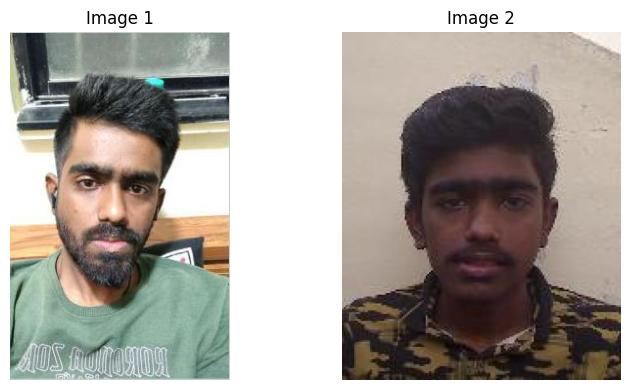

In [ ]:
# import torch
# import numpy as np
# import cv2
# from PIL import Image
# from torchvision import transforms
# from facenet_pytorch import InceptionResnetV1

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Load the fine-tuned model
# fine_tuned_model = InceptionResnetV1(pretrained='vggface2').eval().to(device)  # Use the pretrained FaceNet model
# fine_tuned_model.load_state_dict(torch.load('/content/drive/MyDrive/FineTuningModel/fine_tuned_model_1.pth'),strict=False)
# fine_tuned_model.eval()  # Set model to evaluation mode

# # Define transformation for face images
# transform = transforms.Compose([
#     transforms.Resize((160, 160)),
#     transforms.ToTensor(),
#     transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
# ])

# face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# def get_embedding(image_path, model, transform, device):
#     # Read the image and convert to RGB
#     img = Image.open(image_path).convert("RGB")
#     img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

#     # Detect faces in the image
#     gray = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)
#     faces = face_cascade.detectMultiScale(gray, 1.1, 4)

#     if len(faces) > 0:
#         for (x, y, w, h) in faces:
#             face = img_cv[y:y+h, x:x+w]
#             face_pil = Image.fromarray(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))

#             # Transform the face
#             face_tensor = transform(face_pil).unsqueeze(0).to(device)

#             # Get the embedding from the FaceNet model
#             with torch.no_grad():
#                 embedding = model(face_tensor)  # This will return the 512-dimensional embedding

#             return embedding.cpu().detach().numpy()  # Return the embedding as a numpy array
#     return None  # If no face detected

# def compare_faces(embedding1, embedding2, threshold=0.5):
#     # Compute the Euclidean distance between the embeddings
#     distance = np.linalg.norm(embedding1 - embedding2)
#     print(f"Distance: {distance}")

#     if distance < threshold:
#         print("The faces are the different person.")
#     else:
#         print("The faces are same people.")

# # Paths to the two images to compare
# image1 = '/content/drive/MyDrive/Face_Recognition_Data_1/person1730/CFXPD2700N_0_KYC.jpg'  # Change to your first image path
# image2 = '/content/drive/MyDrive/Face_Recognition_Data_1/person1730/xml_aadhar_photo.jpg'  # Change to your second image path

# # Get embeddings for both images
# embedding1 = get_embedding(image1, fine_tuned_model, transform, device)
# embedding2 = get_embedding(image2, fine_tuned_model, transform, device)

# if embedding1 is not None and embedding2 is not None:
#     # Compare the two embeddings
#     compare_faces(embedding1, embedding2, threshold=0.5)  # You can adjust the threshold based on your data
# else:
#     print("One or both faces were not detected in the images.")


Distance: 0.6646661758422852
The faces are same people.


In [ ]:
import torch
import numpy as np
from PIL import Image
from facenet_pytorch import InceptionResnetV1, MTCNN
from sklearn.metrics.pairwise import cosine_similarity
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load FaceNet model (pretrained or fine-tuned)
model = InceptionResnetV1(pretrained='vggface2').eval().to(device)

# Load fine-tuned weights if available
# model_path = '/content/drive/MyDrive/FineTuningModel/fine_tuned_model_1.pth'
# if os.path.exists(model_path):
#     model.load_state_dict(torch.load(model_path, map_location=device), strict=False)
#     print("✅ Fine-tuned model loaded.")

# Initialize MTCNN for face detection and alignment
mtcnn = MTCNN(image_size=160, margin=0, device=device)

# Function to extract 512-dim embedding from an image
def get_embedding(image_path):
    try:
        img = Image.open(image_path).convert('RGB')
    except Exception as e:
        print(f"❌ Error opening image: {image_path}\n{e}")
        return None

    face = mtcnn(img)
    if face is not None:
        face = face.unsqueeze(0).to(device)
        with torch.no_grad():
            embedding = model(face)
        return embedding.cpu().numpy()
    else:
        print(f"⚠️ No face detected in {image_path}")
        return None

# Function to compare embeddings using cosine similarity
def compare_embeddings_cosine(embedding1, embedding2, threshold=0.5):
    if embedding1 is None or embedding2 is None:
        print("❌ One or both embeddings are missing.")
        return

    similarity = cosine_similarity(embedding1, embedding2)[0][0]
    print(f"Cosine Similarity: {similarity:.4f}")

    if similarity > threshold:
        print("✅ The faces belong to the same person.")
    else:
        print("❌ The faces belong to different people.")

# === Example usage ===

image1_path = '/content/drive/MyDrive/Face_Recognition_Data/person213/CHTPJ2373M_0_KYC.jpg'
image2_path = '/content/drive/MyDrive/Face_Recognition_Data/person213/xml_aadhar_photo.jpg'

embedding1 = get_embedding(image1_path)
embedding2 = get_embedding(image2_path)

compare_embeddings_cosine(embedding1, embedding2, threshold=0.5)  # Threshold ~0.5 is typical for cosine


✅ Fine-tuned model loaded.
Cosine Similarity: 0.7702
✅ The faces belong to the same person.


Running on device: cpu
✅ Fine-tuned model loaded.

Cosine Similarity Score: 77.0186%
✅ Same person


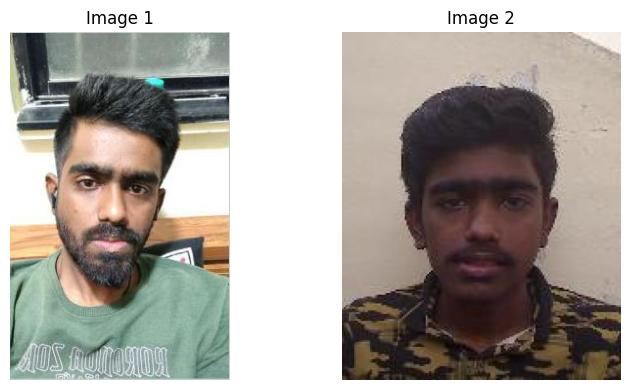

In [ ]:
import torch
import numpy as np
from PIL import Image
from facenet_pytorch import InceptionResnetV1, MTCNN
from sklearn.metrics.pairwise import cosine_similarity
import os
import matplotlib.pyplot as plt

# === Device setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on device: {device}")

# === Load FaceNet Model ===
model = InceptionResnetV1(pretrained='vggface2').eval().to(device)

# Load fine-tuned weights (if available)
model_path = '/content/drive/MyDrive/FineTuningModel/fine_tuned_model_1.pth'
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device), strict=False)
    print("✅ Fine-tuned model loaded.")
else:
    print("⚠️ Using base pretrained FaceNet model.")

# === MTCNN face detector & aligner ===
mtcnn = MTCNN(image_size=160, margin=0, device=device)

# === Function: Extract face embedding ===
def get_embedding(image_path):
    try:
        img = Image.open(image_path).convert('RGB')
        face = mtcnn(img)
        if face is not None:
            face = face.unsqueeze(0).to(device)
            with torch.no_grad():
                embedding = model(face)
            return embedding.cpu().numpy(), img
        else:
            print(f"⚠️ No face detected in: {image_path}")
            return None, img
    except Exception as e:
        print(f"❌ Failed to process image {image_path}: {e}")
        return None, None

# === Function: Cosine similarity comparison ===
def compare_embeddings(embedding1, embedding2, threshold=0.5):
    if embedding1 is None or embedding2 is None:
        return "❌ One or both embeddings are missing."

    similarity = cosine_similarity(embedding1, embedding2)[0][0]
    result = "✅ Same person" if similarity > threshold else "❌ Different people"
    return similarity, result

# === Optional: Display images side by side ===
def show_images(img1, img2, title1="Image 1", title2="Image 2"):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.title(title1)
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(img2)
    plt.title(title2)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# === Paths to face images ===
image1_path = '/content/drive/MyDrive/Face_Recognition_Data/person213/CHTPJ2373M_0_KYC.jpg'
image2_path = '/content/drive/MyDrive/Face_Recognition_Data/person213/xml_aadhar_photo.jpg'

# === Process & Compare ===
embedding1, img1 = get_embedding(image1_path)
embedding2, img2 = get_embedding(image2_path)

if embedding1 is not None and embedding2 is not None:
    similarity, result = compare_embeddings(embedding1, embedding2, threshold=0.5)
    print(f"\nCosine Similarity Score: {similarity*100:.4f}%")
    print(result)
    show_images(img1, img2)
else:
    print("❌ Could not extract embeddings for one or both images.")


Similarity Score: 79.2015%


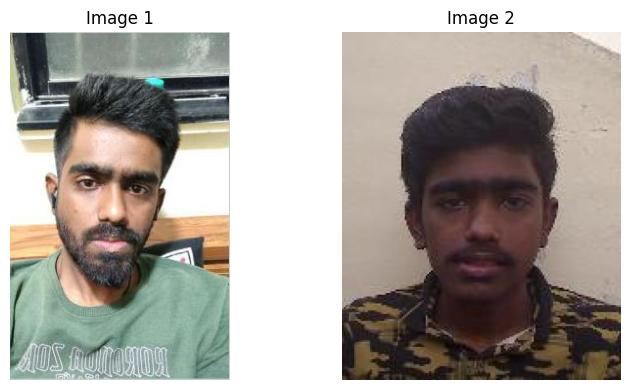

✅ Same person (high similarity)


In [ ]:
import torch
import numpy as np
import cv2
from PIL import Image
from torchvision import transforms
from facenet_pytorch import InceptionResnetV1

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load original FaceNet model with pretrained weights (vggface2 or casia-webface)
model = InceptionResnetV1(pretrained='vggface2').eval().to(device)

# Image transform
transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Haar cascade face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def get_embedding(image_path, model, transform, device):
    img = Image.open(image_path).convert("RGB")
    img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

    gray = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)

    if len(faces) > 0:
        for (x, y, w, h) in faces:
            face = img_cv[y:y+h, x:x+w]
            face_pil = Image.fromarray(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))

            face_tensor = transform(face_pil).unsqueeze(0).to(device)

            with torch.no_grad():
                embedding = model(face_tensor)

            return embedding.squeeze(0).cpu().numpy()
    return None

def cosine_similarity(embedding1, embedding2):
    emb1_norm = embedding1 / np.linalg.norm(embedding1)
    emb2_norm = embedding2 / np.linalg.norm(embedding2)
    similarity = np.dot(emb1_norm, emb2_norm)
    return similarity

def show_images(img1, img2, title1="Image 1", title2="Image 2"):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.title(title1)
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(img2)
    plt.title(title2)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# Image paths
image1_path = '/content/drive/MyDrive/Face_Recognition_Data/person213/CHTPJ2373M_0_KYC.jpg'
image2_path = '/content/drive/MyDrive/Face_Recognition_Data/person213/xml_aadhar_photo.jpg'

# Get embeddings
embedding1 = get_embedding(image1_path, model, transform, device)
embedding2 = get_embedding(image2_path, model, transform, device)

if embedding1 is not None and embedding2 is not None:
    similarity_score = cosine_similarity(embedding1, embedding2)
    print(f"Similarity Score: {similarity_score*100:.4f}%")
    show_images(img1, img2)
    if similarity_score > 0.5:  # You can adjust this threshold
        print("✅ Same person (high similarity)")
    else:
        print("❌ Different person (low similarity)")
else:
    print("Face not detected in one or both images.")


UnboundLocalError: cannot access local variable 'tmp_classes' where it is not associated with a value

25-04-23 19:38:09 - Directory /root/.deepface has been created
25-04-23 19:38:09 - Directory /root/.deepface/weights has been created


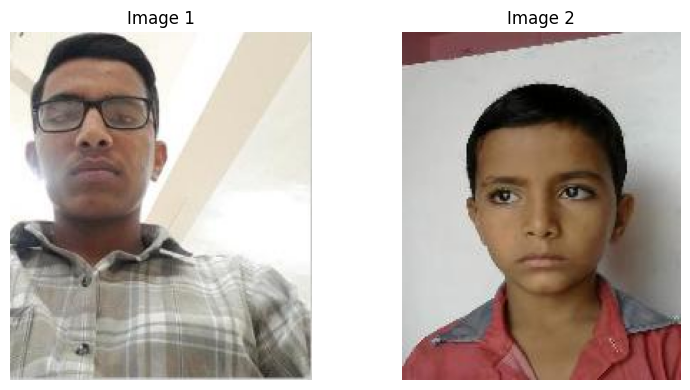

Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facenet_weights.h5
To: /root/.deepface/weights/facenet_weights.h5


25-04-23 19:38:14 - facenet_weights.h5 will be downloaded...


100%|██████████| 92.2M/92.2M [00:00<00:00, 206MB/s]



🔍 DeepFace Result:
Verified: False
Distance: 0.9249
Threshold: 0.4000
